## Resourcing

Socrata does nevertheless have a catalog API, which, in every other respect, seems to be quite good. Chicago's [RSocrata client](https://github.com/Chicago/RSocrata) has an interface to it, but I'm a Python programmer, and [sodapy](https://github.com/xmunoz/sodapy) is dataset-specific. So I rolled my own, which I may have developed into a full module by the time you read this.

Here are the definitions I use:

* **Endpoint**: Any Socrata resource.
* **Dataset**: Any tabular or geospatial endpoint on Socrata.
* **Table**: A tabular dataset.

## Getting the Data

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
endpoints = json.loads(open("../data/portal-contents-raw.json").read())

In [10]:
tabular_datasets = [d for d in endpoints if d['resource']['type'] == 'dataset']

In [11]:
datasets = json.loads(open("../data/datasets-new.json").read())

In [12]:
pd.Series([d['resource']['type'] for d in endpoints]).value_counts()

filter      6881
map         1187
dataset     1149
chart        366
href         181
file         100
datalens      18
calendar       7
story          2
dtype: int64

In [8]:
# Run this to redo the Socrata data dump.
# Note: this takes a while to execute.
# !python ../src/load_datasets.py

Here is the structure of the metadata response we get from the Socrata API pull:

In [7]:
endpoints[0]

{'classification': {'categories': ['finance',
   'environment',
   'housing & development'],
  'domain_category': 'Housing & Development',
  'domain_metadata': [{'key': 'Update_Automation', 'value': 'Yes'},
   {'key': 'Update_Update-Frequency', 'value': 'Daily'},
   {'key': 'Dataset-Information_Agency',
    'value': 'Department of Buildings (DOB)'}],
  'domain_tags': ['buildings', 'dob', 'job'],
  'tags': []},
 'link': 'https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2',
 'metadata': {'domain': 'data.cityofnewyork.us'},
 'permalink': 'https://data.cityofnewyork.us/d/ic3t-wcy2',
 'resource': {'attribution': 'Department of Buildings (DOB)',
  'columns_description': ['Loft Board',
   "Owner's  Phone #",
   'Date when job is assigned to plan examiner',
   'Date when job is prefiled',
   'Existing Height',
   'City ',
   'Zoning Distr 1',
   'House Number of Residence or Commercial Property',
   'Number assigned by City Planning to a specific building',

## Counts

**Endpoints**

In [14]:
len(endpoints)

9891

**Datasets**

In [15]:
len(datasets)

1597

**Tables**

In [16]:
len(tabular_datasets)

1149

## Hashes

Socrata endpoints are anchored by unique hases at the end of their URIs. `h9gi-nx95`, for example, points to the NYPD Motor Vehicle collision dataset, equally accessible at `https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95` (its actual URI) and at `https://data.cityofnewyork.us/-/-/h9gi-nx95` (a redirect).

If batch processing all datasets somehow is a goal, it's pretty easy to back out the actual dataset points:

In [17]:
endpoint_hashes = pd.Series([d['permalink'].split("/")[-1] for d in endpoints])

In [18]:
endpoint_hashes.head(5)

0    ic3t-wcy2
1    dpec-ucu7
2    8wbx-tsch
3    xjfq-wh2d
4    jb3k-j3gp
dtype: object

These are all you need to build a valid URL. So if, for example, you wanted to programmatically, download all of the datasets on the NYC portal (or some subset thereof), you can throw these at [sodapy](https://github.com/xmunoz/sodapy) and digest all of it.

The process for pulling datasets and tables is exactly the same.

## Domain Categorization

In [19]:
def endpoint_categories(data):
    """
    Returns a pd.Series mapping datasets to endpoint categories.
    """
    return pd.Series(list(map(lambda d: d['classification']['domain_category'], data)))

**All Endpoints**

In [20]:
endpoint_categories(endpoints).value_counts()

Social Services          3752
City Government          1882
Transportation           1141
Housing & Development     751
Public Safety             507
Health                    455
Education                 422
Environment               333
Business                  227
NYC BigApps               209
Recreation                119
                           93
dtype: int64

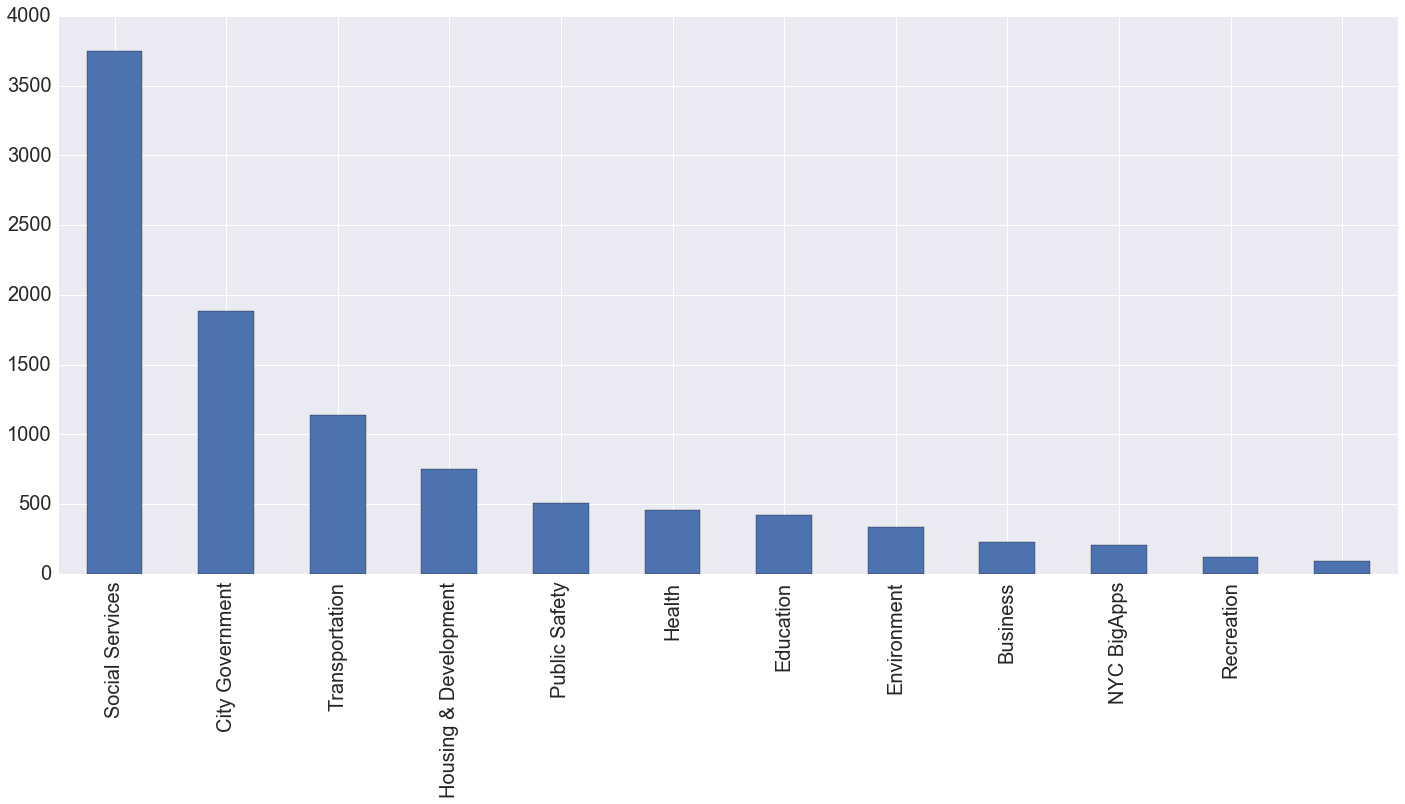

In [21]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Datasets**

In [22]:
endpoint_categories(datasets).value_counts()

City Government          398
Education                249
Public Safety            181
Housing & Development    167
Transportation           143
Social Services          112
Environment               99
Recreation                72
Business                  56
NYC BigApps               54
                          35
Health                    31
dtype: int64

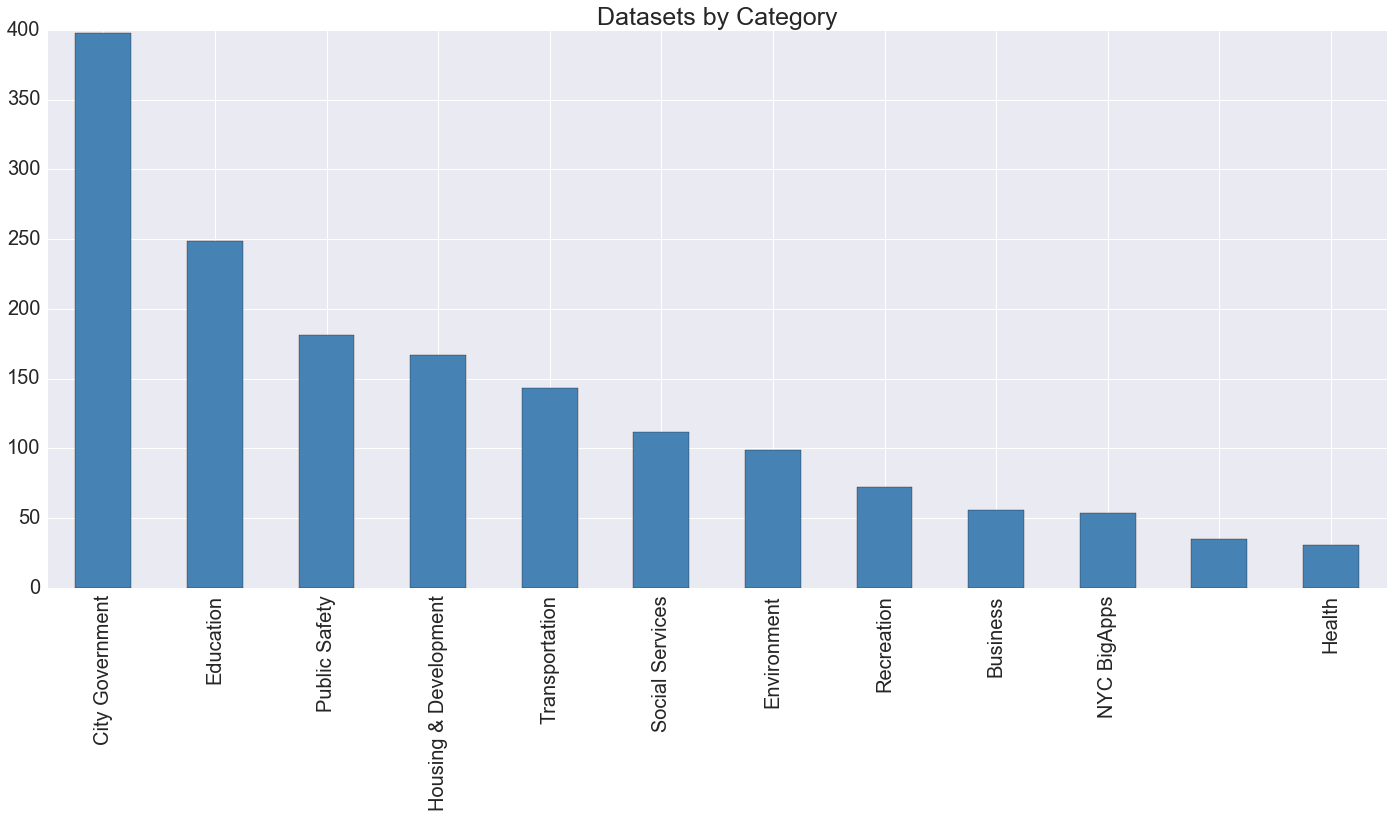

In [23]:
fig = plt.figure(figsize=(24, 10))
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')
plt.title('Datasets by Category', fontsize=25)

**Tables**

In [24]:
endpoint_categories(tabular_datasets).value_counts()

City Government          288
Education                221
Public Safety            153
Housing & Development    137
Social Services           87
Environment               68
Transportation            67
Business                  43
Recreation                32
Health                    26
                          20
NYC BigApps                7
dtype: int64

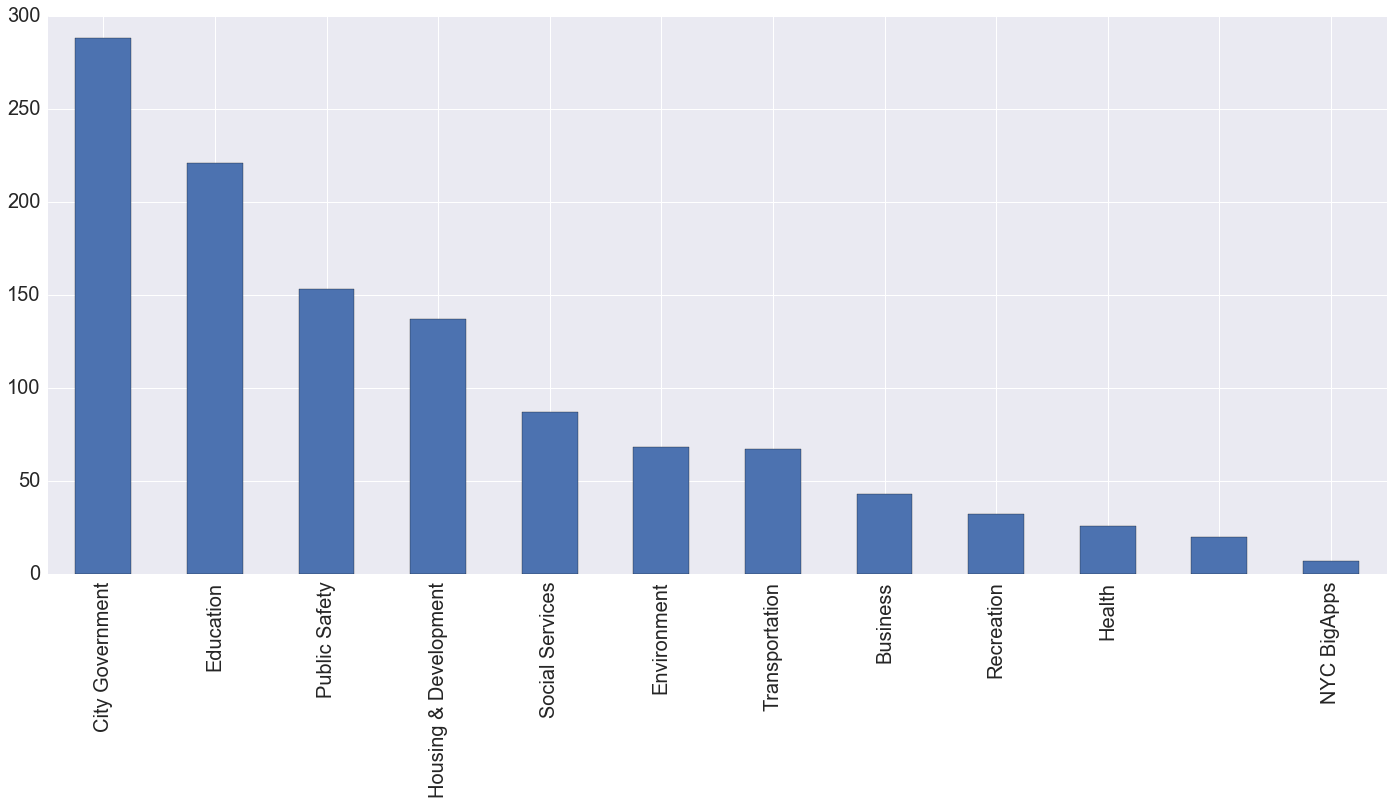

In [25]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Reliability**

These counts are known to be reliable insofar as simple categorization is reliable.

### Update Automation

In [26]:
def endpoint_automations(endpoints):
    """
    Returns a pd.Series mapping endpoints to their automation type.
    """
    def get_update_automation_type(endpoint):
        # Get the "domain metadata".
        domain_metadata = endpoint['classification']['domain_metadata']
        # Format example:
        # [{'key': 'Update_Automation', 'value': 'Yes'},
        #  {'key': 'Update_Update-Frequency', 'value': 'Daily'},
        #  {'key': 'Dataset-Information_Agency', 'value': 'Department of Buildings (DOB)'}]
        #
        # If Update_Automation is included it should be *first* entry.
        # But we don't want to just check for that! Because this could change in the future.
        # Instead we need to implement a search strategy.
        # First get all_keys.
        all_keys = [d['key'] for d in domain_metadata]
        # Then try to get the index. This raises a ValueError if it doesn't find anything---return None in that case.
        try:
            # If we didn't fail and return None, pick and return it.
            return domain_metadata[all_keys.index("Update_Automation")]['value']
        except ValueError:
            return None

    return pd.Series(map(get_update_automation_type, endpoints))

**Endpoints**

In [27]:
endpoint_automations(endpoints).value_counts(dropna=False)

NaN    6637
Yes    2236
No     1018
dtype: int64

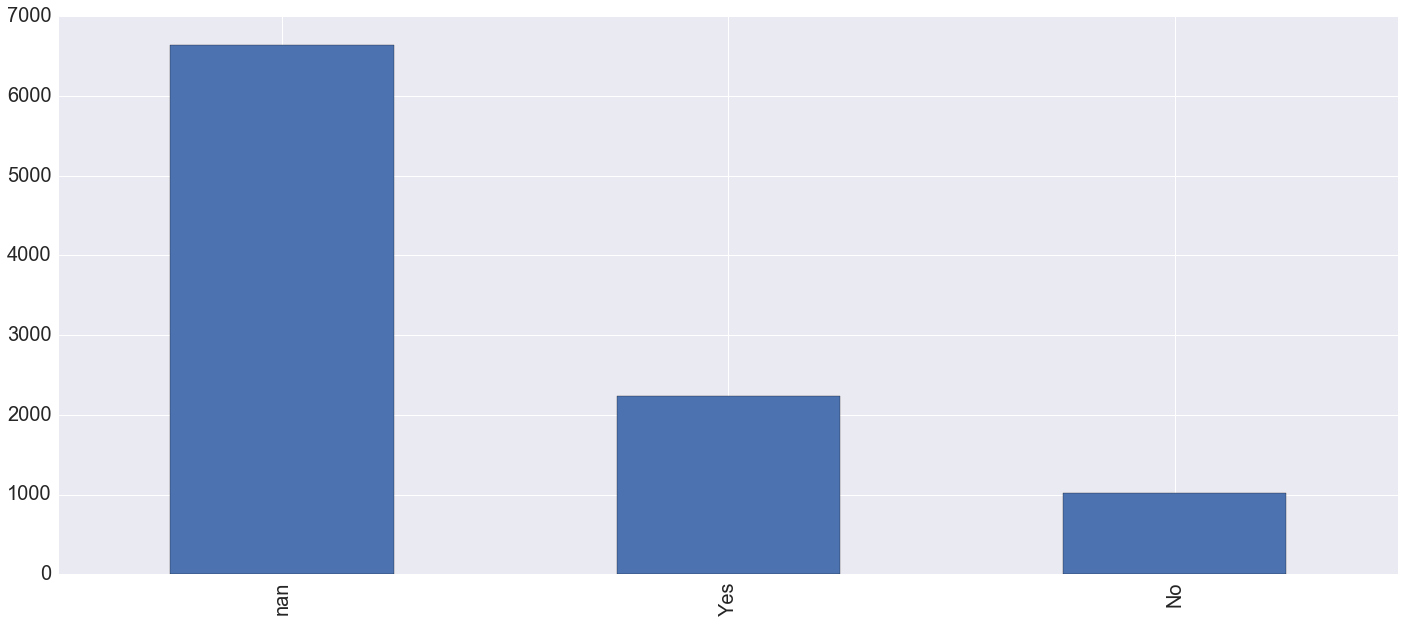

In [28]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Datasets**

In [34]:
endpoint_automations(datasets).value_counts(dropna=False)

NaN    967
No     459
Yes    171
dtype: int64

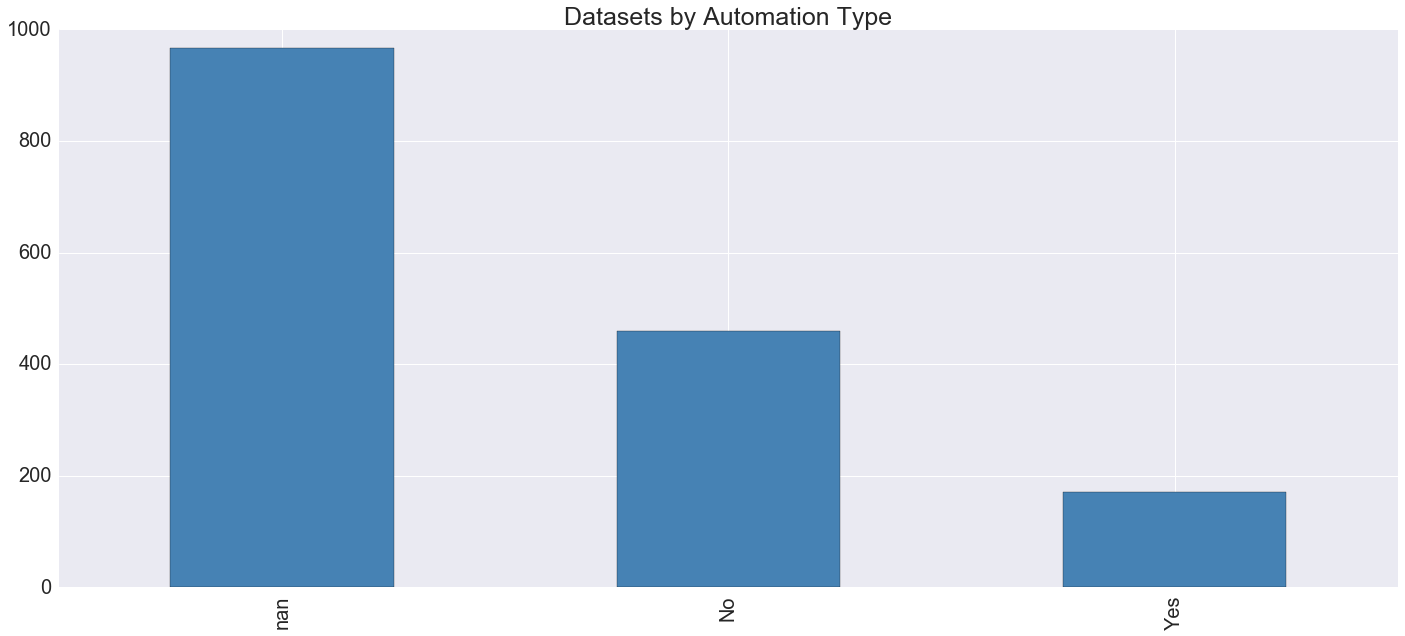

In [33]:
fig = plt.figure(figsize=(24, 10))
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')
plt.title('Datasets by Automation Type', fontsize=25)

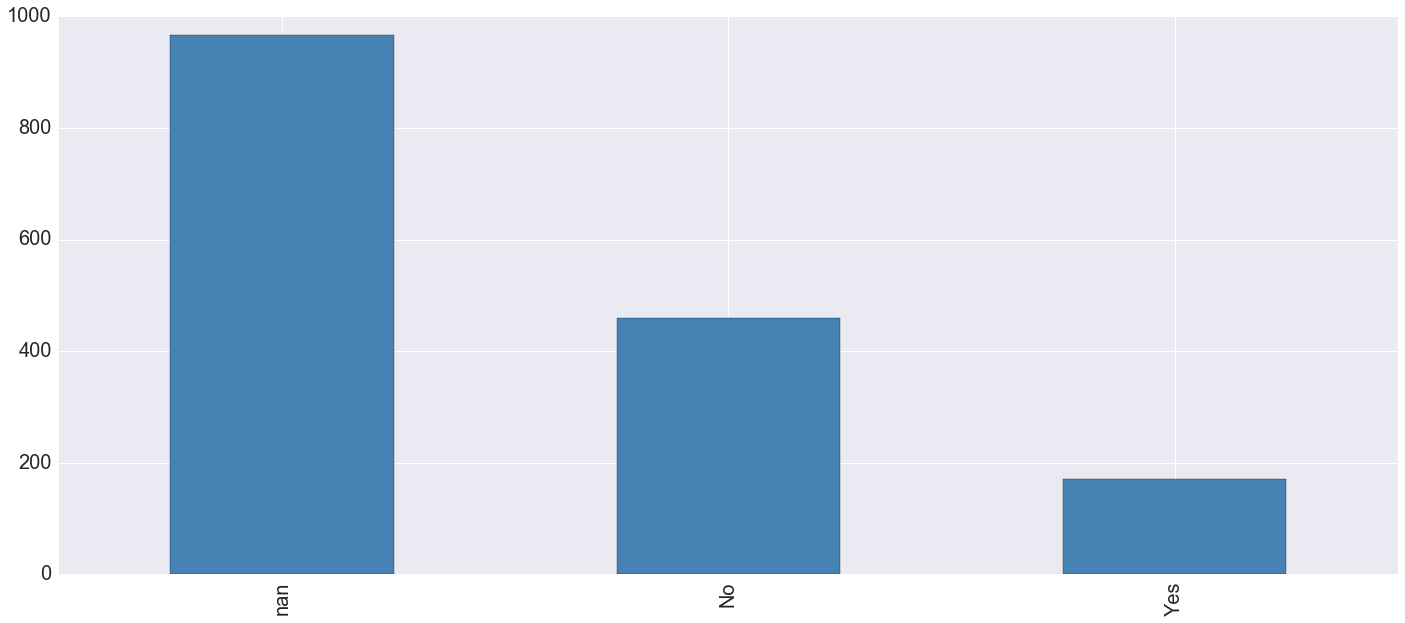

In [35]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')

**Tables**

In [36]:
endpoint_automations(tabular_datasets).value_counts(dropna=False)

NaN    742
No     243
Yes    164
dtype: int64

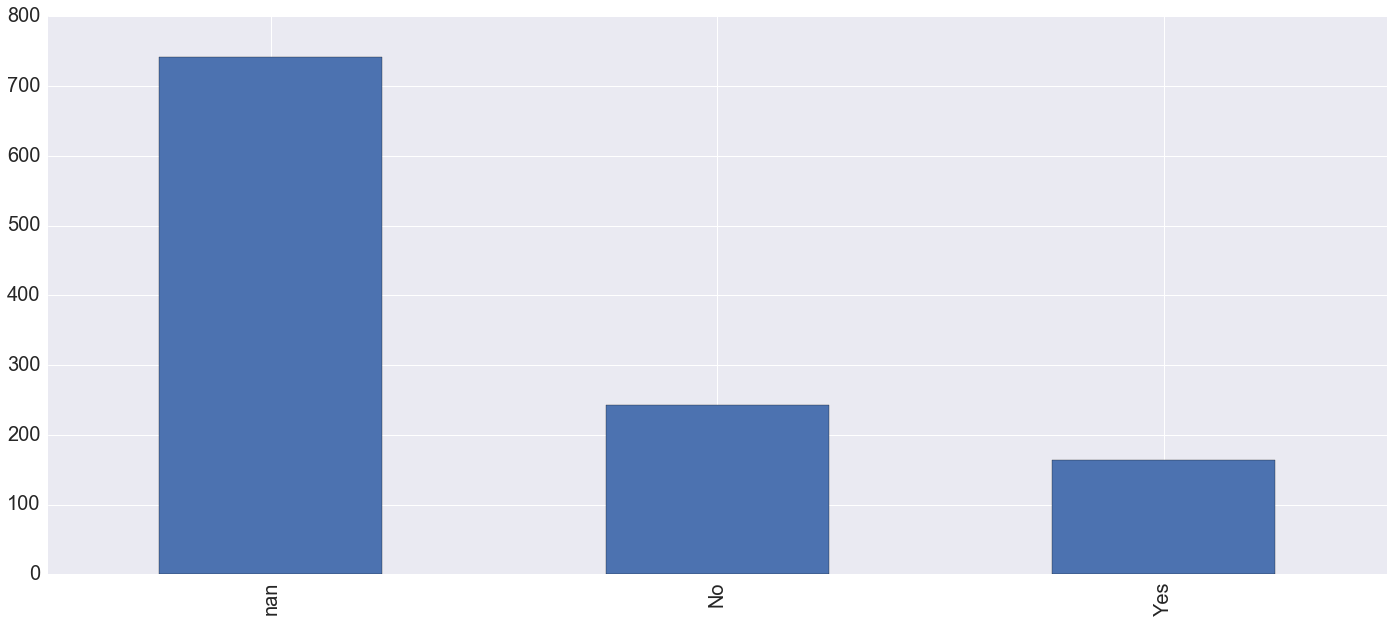

In [37]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

### Update Frequency

In [38]:
def endpoint_update_frequency(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update frequencies.
    """
    def get_update_frequency(endpoint):
        # Get the "domain metadata".
        domain_metadata = endpoint['classification']['domain_metadata']
        # Format example:
        # [{'key': 'Update_Automation', 'value': 'Yes'},
        #  {'key': 'Update_Update-Frequency', 'value': 'Daily'},
        #  {'key': 'Dataset-Information_Agency', 'value': 'Department of Buildings (DOB)'}]
        #
        # First get all_keys.
        all_keys = [d['key'] for d in domain_metadata]
        # Then try to get the index. This raises a ValueError if it doesn't find anything---return None in that case.
        try:
            # If we didn't fail and return None, pick and return it.
            return domain_metadata[all_keys.index("Update_Update-Frequency")]['value']
        except ValueError:
            # Otherwise throw out a None.
            return None

    return pd.Series(list(map(get_update_frequency, endpoints)))

**Endpoints**

In [39]:
endpoint_update_frequency(endpoints).value_counts(dropna=False)

Daily                       5750
As needed                   1277
Annually                     632
Monthly                      567
Historical Data              509
Weekdays                     429
NaN                          279
Weekly                       143
Several times per day         86
Quarterly                     66
Biannually                    62
Several times per minute      47
Biweekly                      17
2 to 4 times per year         10
Triannually                    5
Bimonthly                      4
Unknown                        4
                               3
Annually                       1
dtype: int64

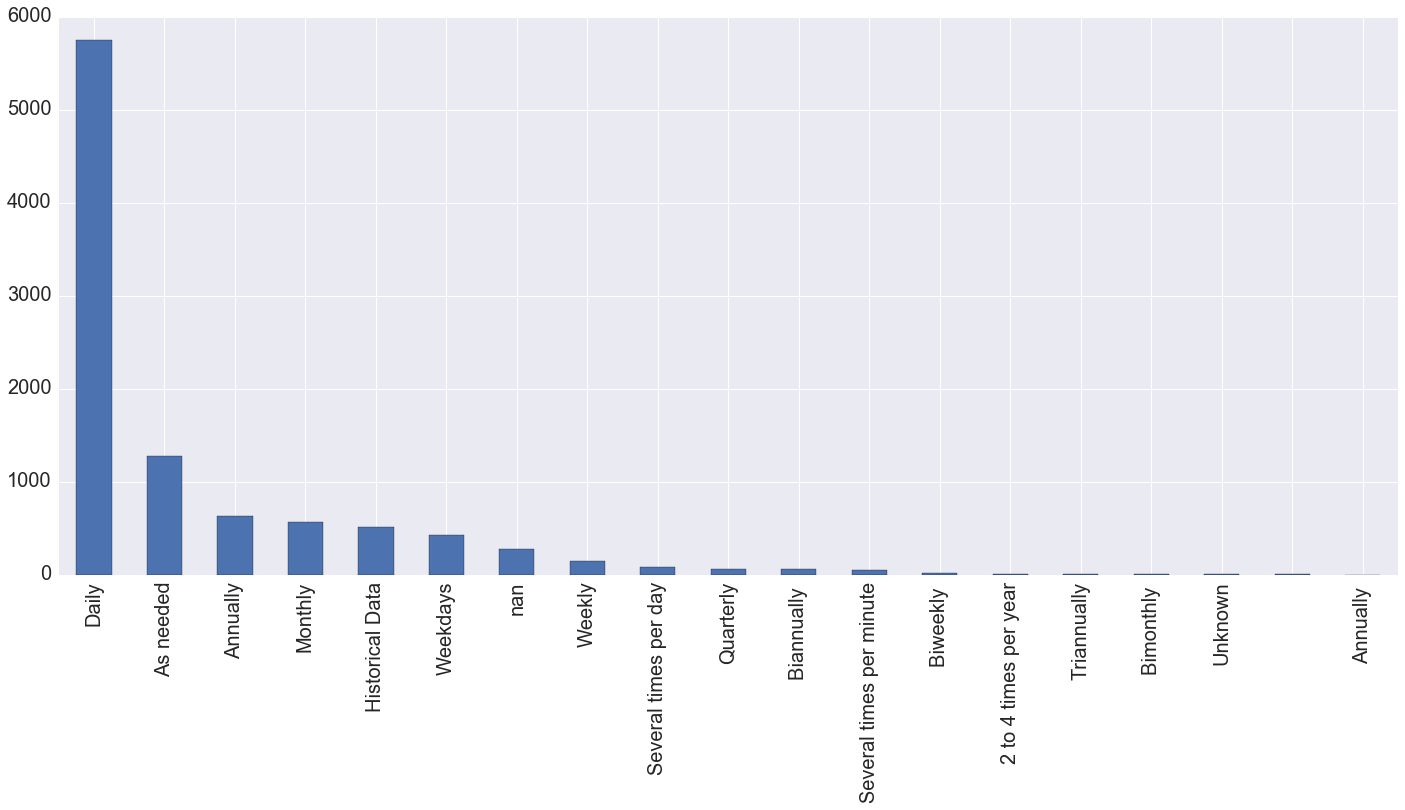

In [40]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Datasets**

In [43]:
endpoint_update_frequency(datasets).value_counts(dropna=False)

As needed                561
Annually                 373
Historical Data          181
NaN                      157
Monthly                  104
Daily                     81
Weekly                    42
Biannually                38
Quarterly                 34
Triannually                5
Weekdays                   5
Unknown                    3
                           3
Bimonthly                  3
Biweekly                   2
2 to 4 times per year      2
Several times per day      2
Annually                   1
dtype: int64

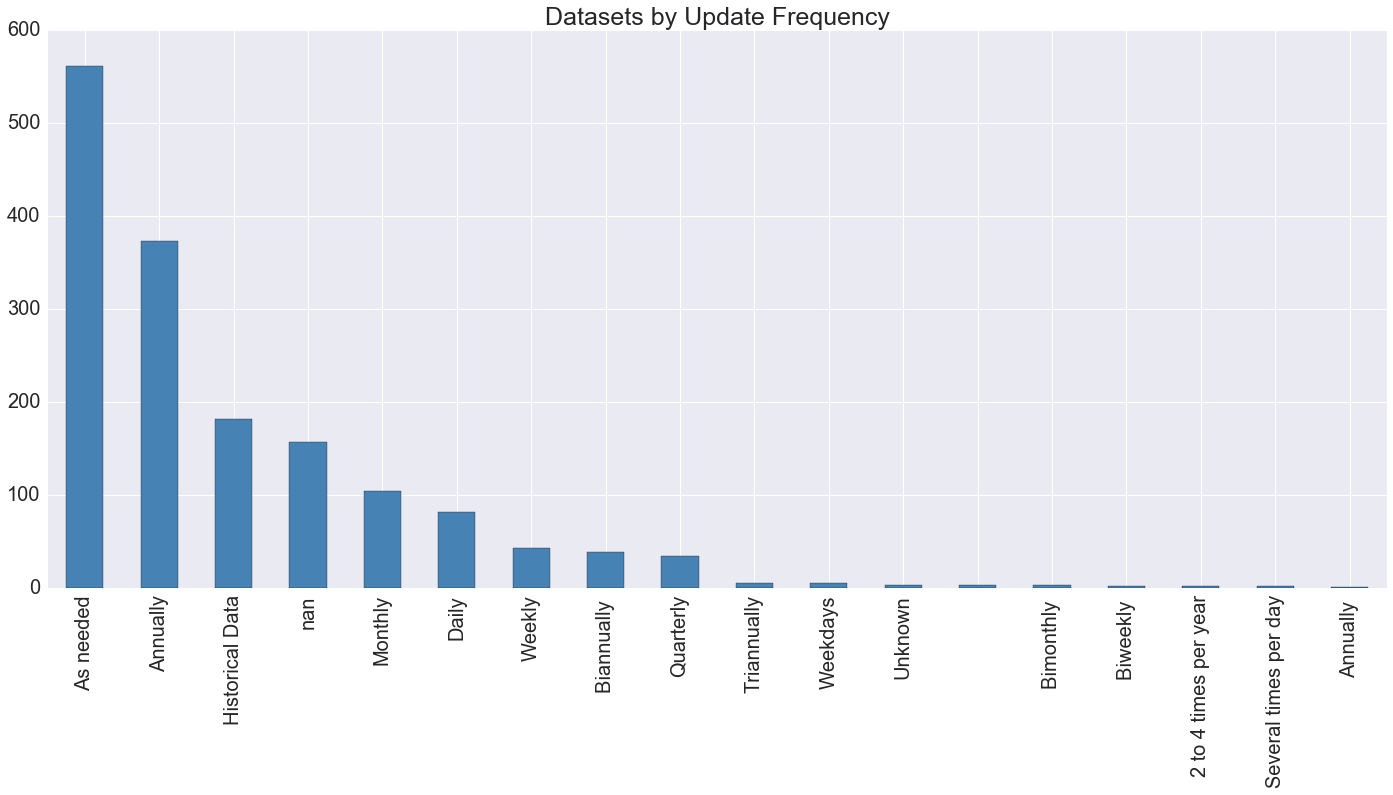

In [42]:
fig = plt.figure(figsize=(24, 10))
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')
plt.title('Datasets by Update Frequency', fontsize=25)

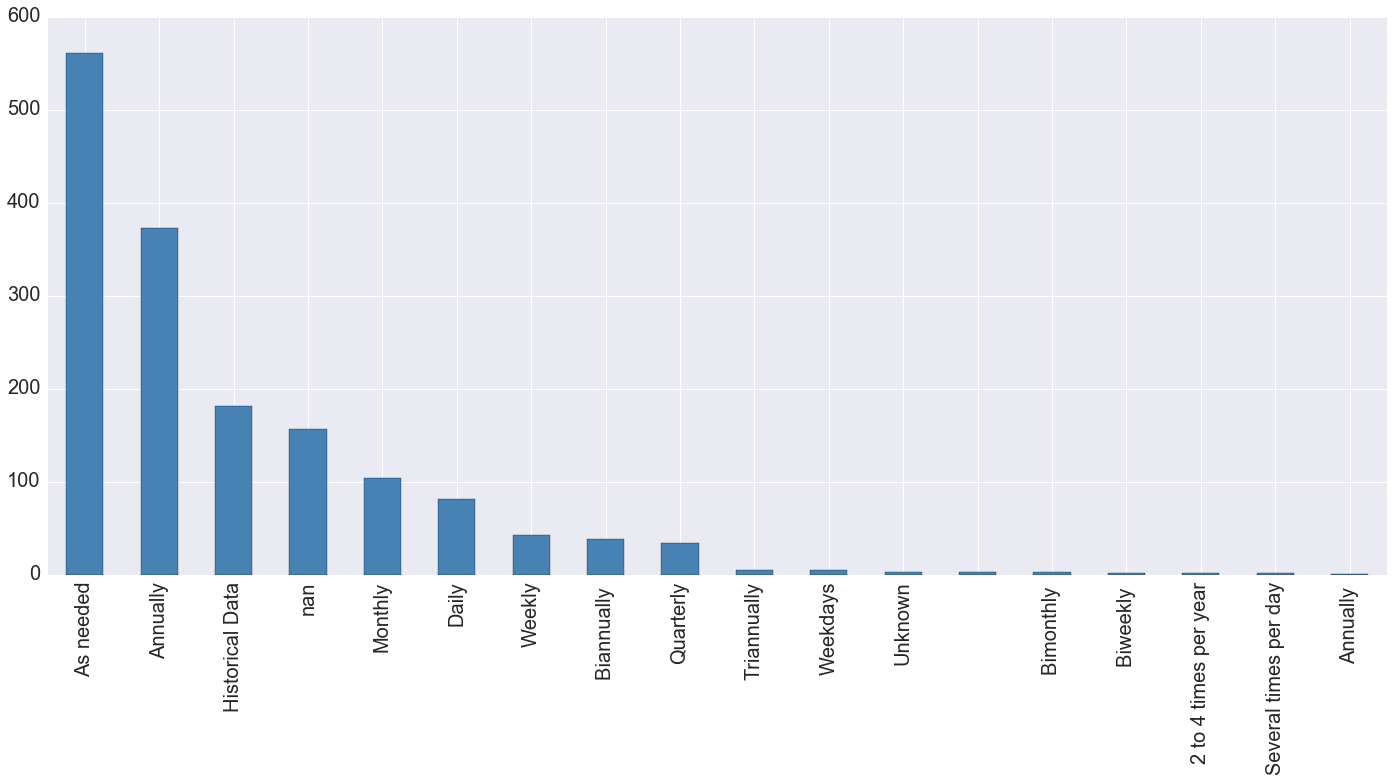

In [44]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')

**Tables**

In [45]:
endpoint_update_frequency(tabular_datasets).value_counts(dropna=False)

Annually                    336
As needed                   234
NaN                         150
Historical Data             146
Monthly                     102
Daily                        55
Weekly                       37
Biannually                   35
Quarterly                    29
Triannually                   5
Weekdays                      5
Bimonthly                     3
                              3
Unknown                       3
Several times per day         2
Biweekly                      1
2 to 4 times per year         1
Several times per minute      1
Annually                      1
dtype: int64

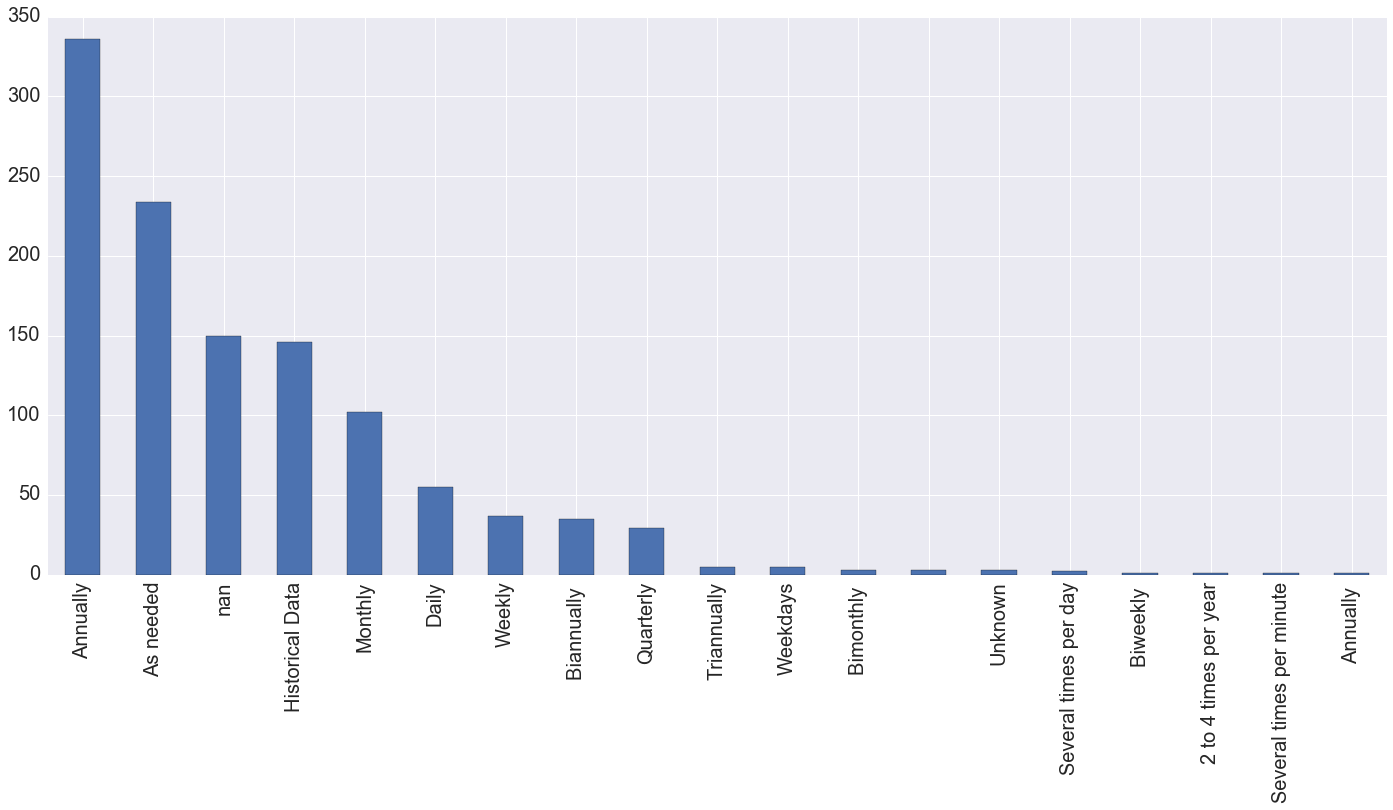

In [46]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

What's that one updated several times per minute?

In [47]:
tabular_hashes = pd.Series([d['permalink'].split("/")[-1] for d in tabular_datasets])

tabular_hashes[endpoint_update_frequency(tabular_datasets) == 'Several times per minute']

37    tdsx-cvye
dtype: object

Oh. Go figure.

### Dataset Ownership

Note: this uses `information_agency` under `domain_metadata`. There's also `resource_attribution` under `resource`, but that seems to be a lot less clean&mdash;doing things like substiting `NYPD` for `New York Police Department (NYPD)`, for example. Though I believe technically these fields are a little different&mdash;one is who *provided* the dataset, one is who *made* it&mdash;but I think it makes little real difference one way or the other.

In [48]:
def endpoint_ownership(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update frequencies.
    """
    def get_endpoint_owner(endpoint):
        # Get the "domain metadata".
        domain_metadata = endpoint['classification']['domain_metadata']
        # Format example:
        # [{'key': 'Update_Automation', 'value': 'Yes'},
        #  {'key': 'Update_Update-Frequency', 'value': 'Daily'},
        #  {'key': 'Dataset-Information_Agency', 'value': 'Department of Buildings (DOB)'}]
        #
        # First get all_keys.
        all_keys = [d['key'] for d in domain_metadata]
        # Then try to get the index. This raises a ValueError if it doesn't find anything---return None in that case.
        try:
            # If we didn't fail and return None, pick and return it.
            return domain_metadata[all_keys.index("Dataset-Information_Agency")]['value']
        except ValueError:
            # Otherwise throw out a None.
            return None

    return pd.Series(list(map(get_endpoint_owner, endpoints)))

**Endpoints**

In [49]:
endpoint_ownership(endpoints).value_counts(dropna=False)

311                                                                  3565
Taxi and Limousine Commission (TLC)                                   929
Office of Administrative Trials and Hearings (OATH)                   613
Department of Finance (DOF)                                           451
Department of Health and Mental Hygiene (DOHMH)                       434
Police Department (NYPD)                                              428
Department of Education (DOE)                                         344
Department of Citywide Administrative Services (DCAS)                 325
Department of Buildings (DOB)                                         318
Department of City Planning (DCP)                                     241
Department of Parks and Recreation (DPR)                              203
Department of Information Technology & Telecommunications (DoITT)     193
Metropolitan Transportation Authority (MTA)                           138
Civilian Complaint Review Board (CCRB)

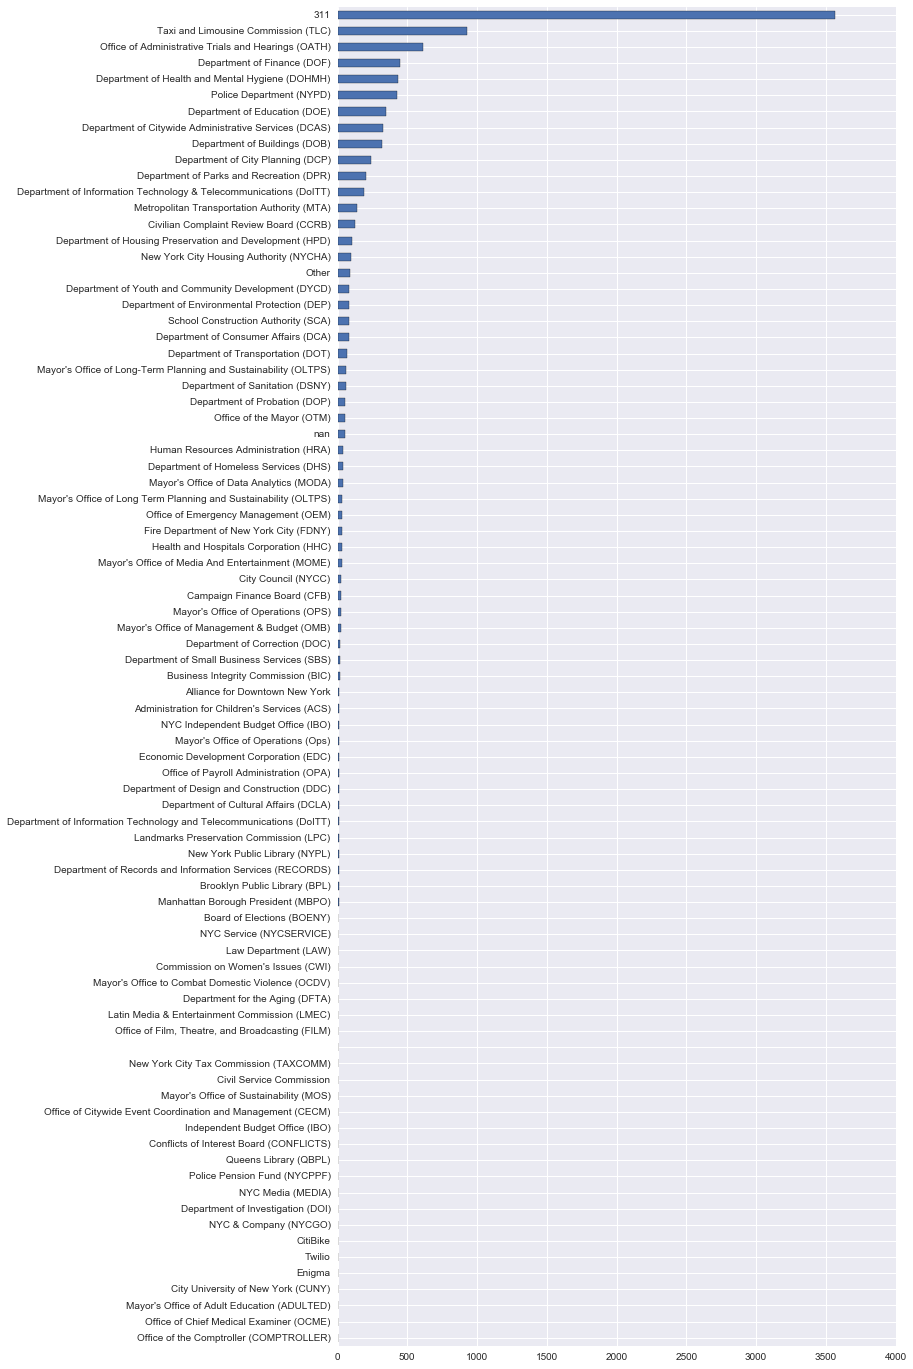

In [50]:
_.sort_values(ascending=True).plot(kind='barh', figsize=(10, 24))

**Datasets**

In [51]:
endpoint_ownership(datasets).value_counts(dropna=False)

Department of Education (DOE)                                        210
Civilian Complaint Review Board (CCRB)                               118
Department of City Planning (DCP)                                    109
Department of Finance (DOF)                                           82
Department of Parks and Recreation (DPR)                              79
Department of Information Technology & Telecommunications (DoITT)     79
Taxi and Limousine Commission (TLC)                                   74
Other                                                                 63
Department of Probation (DOP)                                         51
School Construction Authority (SCA)                                   46
Department of Transportation (DOT)                                    46
Department of Environmental Protection (DEP)                          45
Department of Youth and Community Development (DYCD)                  42
Office of the Mayor (OTM)                          

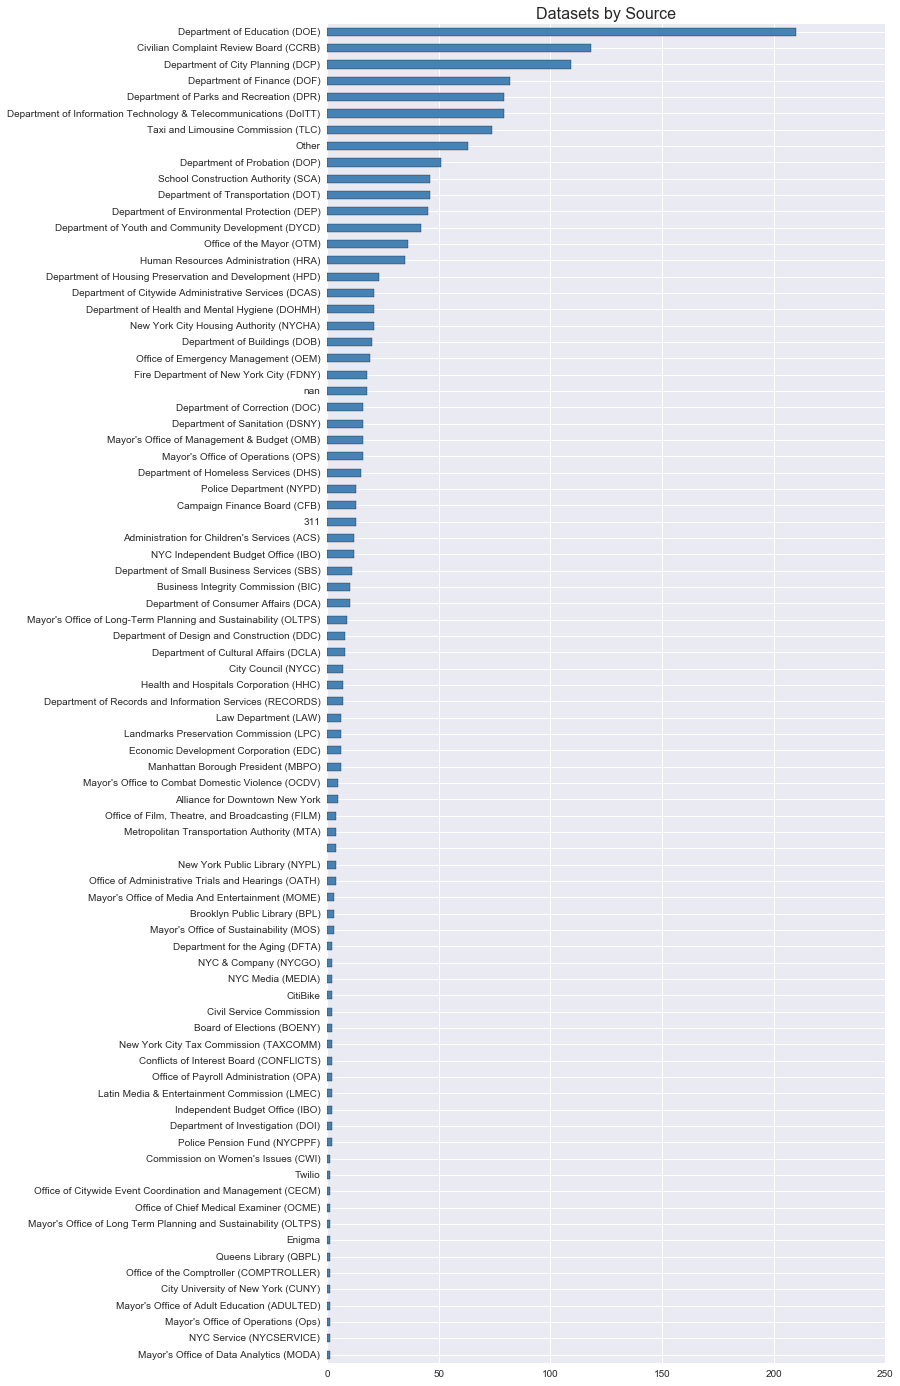

In [52]:
fig = plt.figure(figsize=(24, 10))
_.sort_values(ascending=True).plot(kind='barh', figsize=(10, 24), color='steelblue')
plt.title('Datasets by Source', fontsize=16)

**Tables**

In [53]:
endpoint_ownership(tabular_datasets).value_counts(dropna=False)

Department of Education (DOE)                                        186
Civilian Complaint Review Board (CCRB)                               120
Department of Finance (DOF)                                           71
Department of Probation (DOP)                                         50
Taxi and Limousine Commission (TLC)                                   48
School Construction Authority (SCA)                                   42
Department of Environmental Protection (DEP)                          39
Department of Youth and Community Development (DYCD)                  35
Human Resources Administration (HRA)                                  35
Department of City Planning (DCP)                                     34
Department of Information Technology & Telecommunications (DoITT)     27
Office of the Mayor (OTM)                                             26
Department of Housing Preservation and Development (HPD)              22
Department of Citywide Administrative Services (DCA

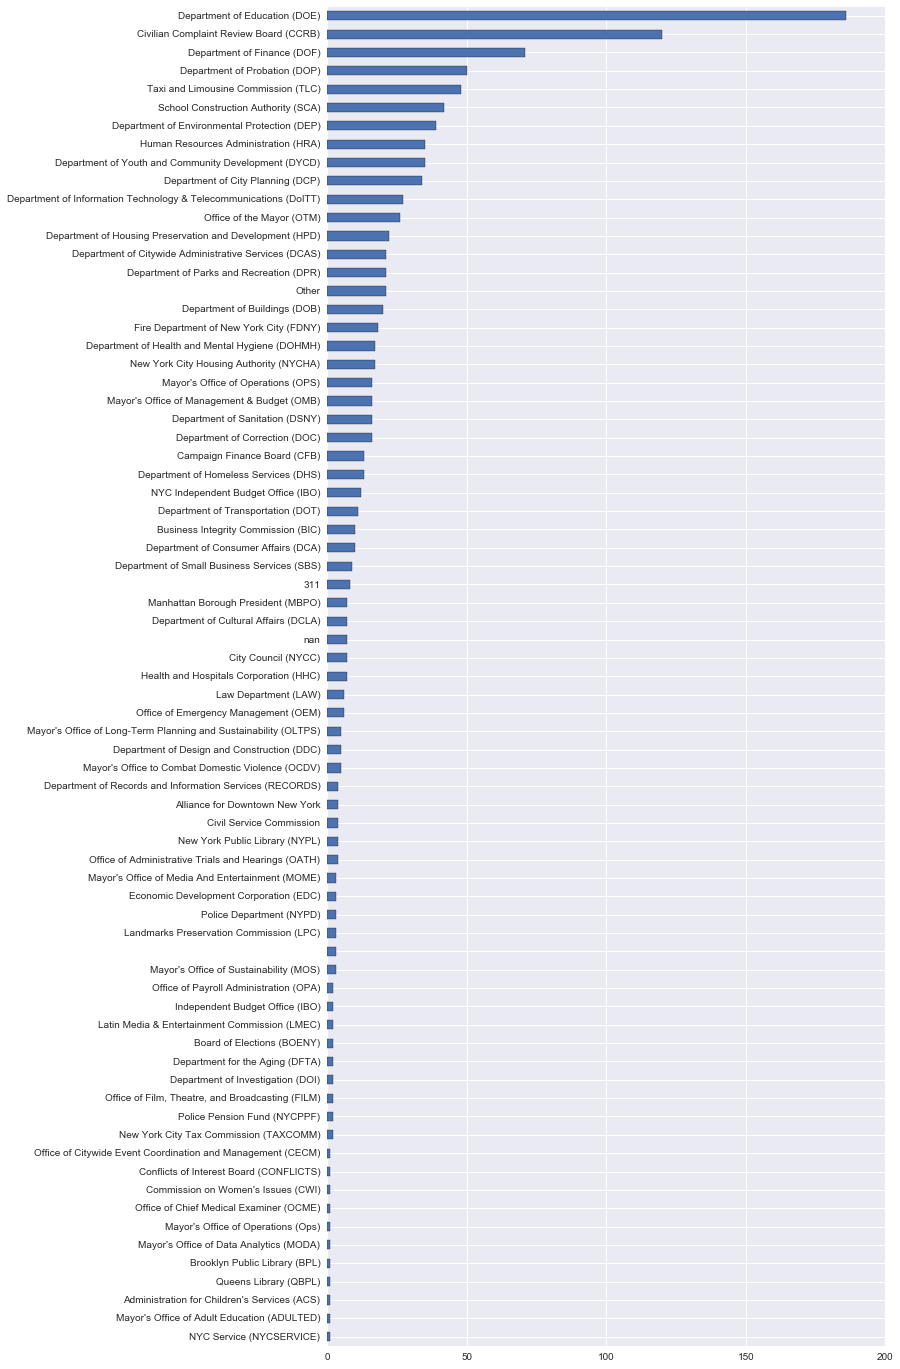

In [54]:
_.sort_values(ascending=True).plot(kind='barh', figsize=(10, 24))

### Creation Date


In [55]:
def endpoint_creation_dates(endpoints):
    """
    Returns a pd.Series mapping endpoints to their creation times.
    """
    return pd.to_datetime(pd.Series(list(map(lambda d: d['resource']['createdAt'], endpoints))))

**Endpoints**

What is the first-ever endpoint?

In [56]:
endpoint_creation_dates(endpoints).sort_values().head(5)

320    2010-11-03 17:15:45
44     2011-07-26 16:26:28
109    2011-07-26 19:48:24
113    2011-07-26 19:56:27
1190   2011-07-26 19:59:04
dtype: datetime64[ns]

In [57]:
endpoints[endpoint_creation_dates(endpoints).sort_values().index[0]]['resource']['id']

'xszr-btpb'

> Electronics Stores
>
> A list of electronics stores that have a current DCA license as of the run date.

Well that's weird. The time lag between the first entry and the last one is also very strange.

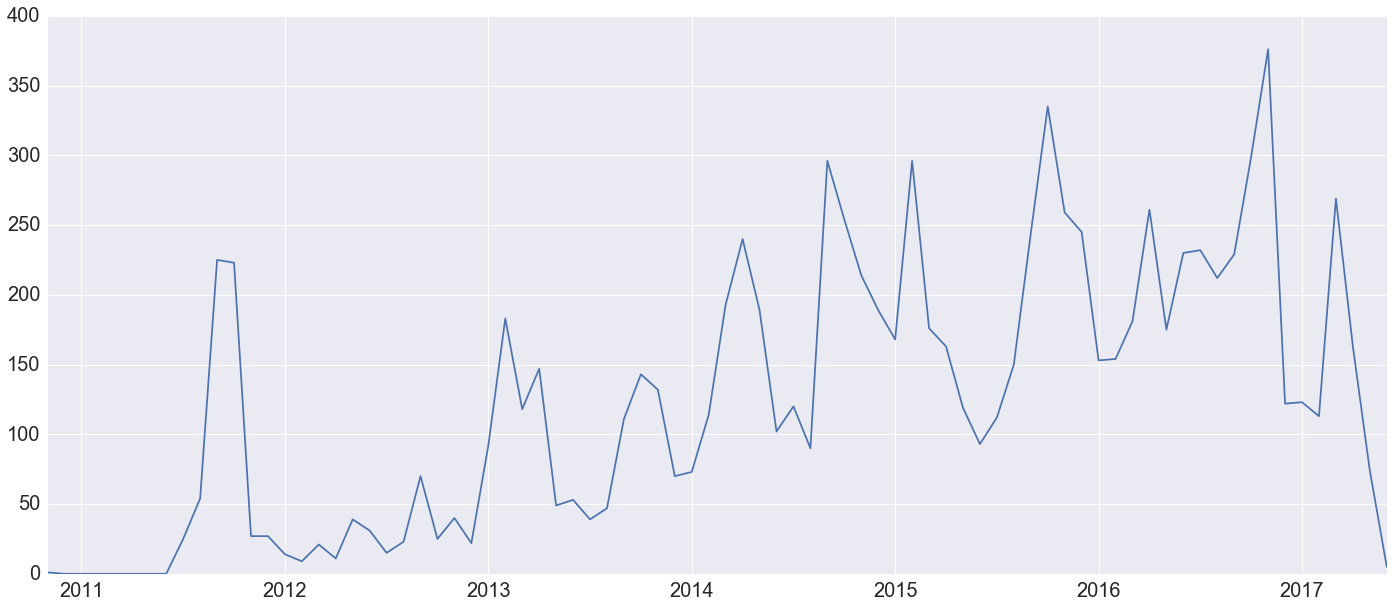

In [58]:
# Monthly endpoint creation
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('M').count().plot(figsize=(24, 10),
                                                                                                             fontsize=20)

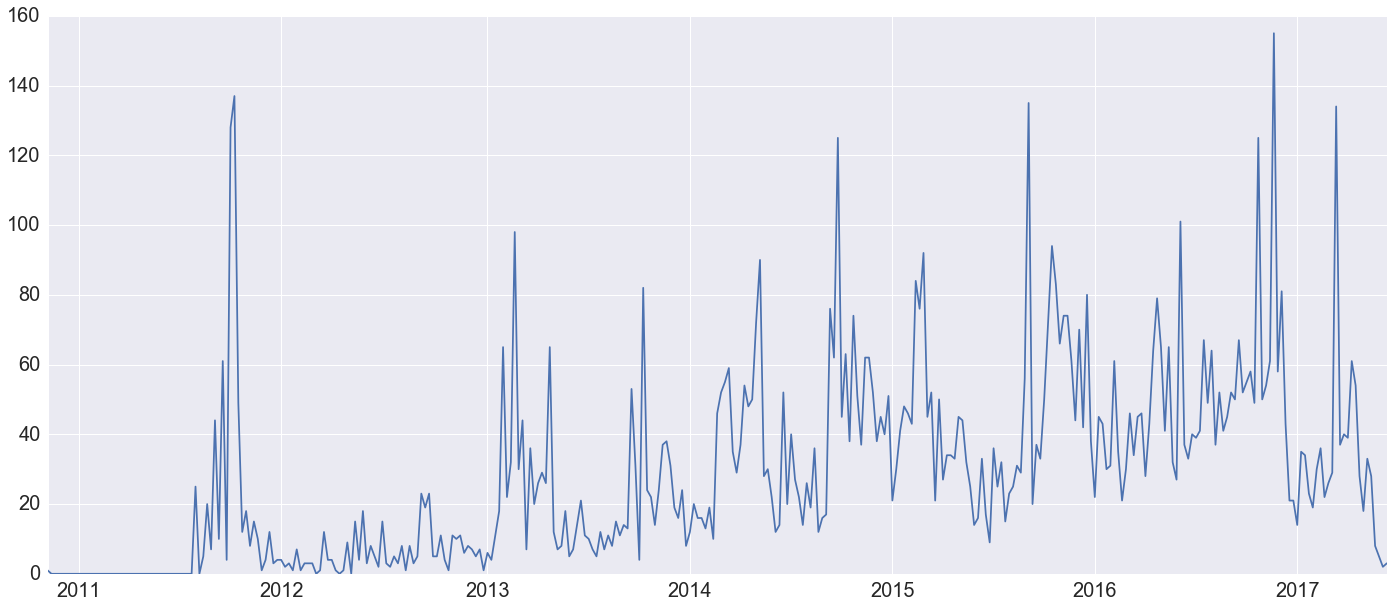

In [59]:
# Weekly endpoint creation
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W').count().plot(figsize=(24, 10),
                                                                                                             fontsize=20)

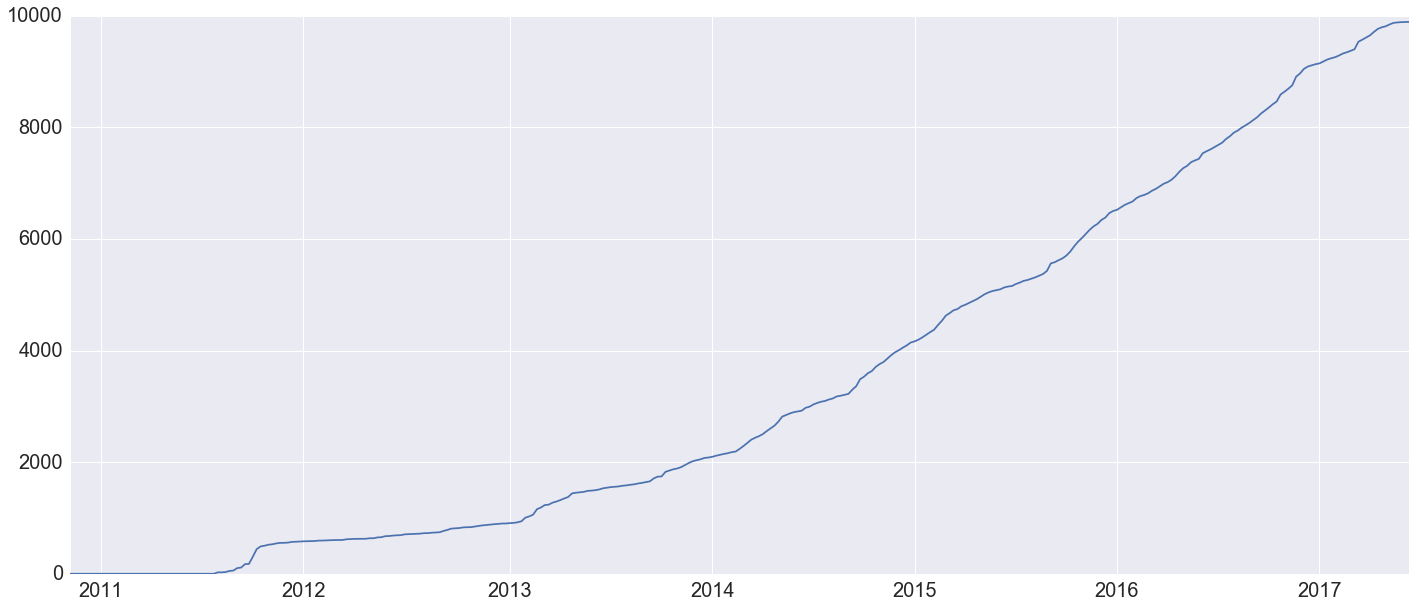

In [60]:
# Cumulative endpoint count.
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

In [61]:
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W')

DatetimeIndexResampler [freq=<Week: weekday=6>, axis=0, closed=right, label=right, convention=start, base=0]

In [62]:
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W').count().cumsum()

2010-11-07       1
2010-11-14       1
2010-11-21       1
2010-11-28       1
2010-12-05       1
2010-12-12       1
2010-12-19       1
2010-12-26       1
2011-01-02       1
2011-01-09       1
2011-01-16       1
2011-01-23       1
2011-01-30       1
2011-02-06       1
2011-02-13       1
2011-02-20       1
2011-02-27       1
2011-03-06       1
2011-03-13       1
2011-03-20       1
2011-03-27       1
2011-04-03       1
2011-04-10       1
2011-04-17       1
2011-04-24       1
2011-05-01       1
2011-05-08       1
2011-05-15       1
2011-05-22       1
2011-05-29       1
              ... 
2016-11-20    8909
2016-11-27    8967
2016-12-04    9048
2016-12-11    9091
2016-12-18    9112
2016-12-25    9133
2017-01-01    9147
2017-01-08    9182
2017-01-15    9216
2017-01-22    9239
2017-01-29    9258
2017-02-05    9288
2017-02-12    9324
2017-02-19    9346
2017-02-26    9372
2017-03-05    9401
2017-03-12    9535
2017-03-19    9572
2017-03-26    9612
2017-04-02    9651
2017-04-09    9712
2017-04-16  

**Datasets**

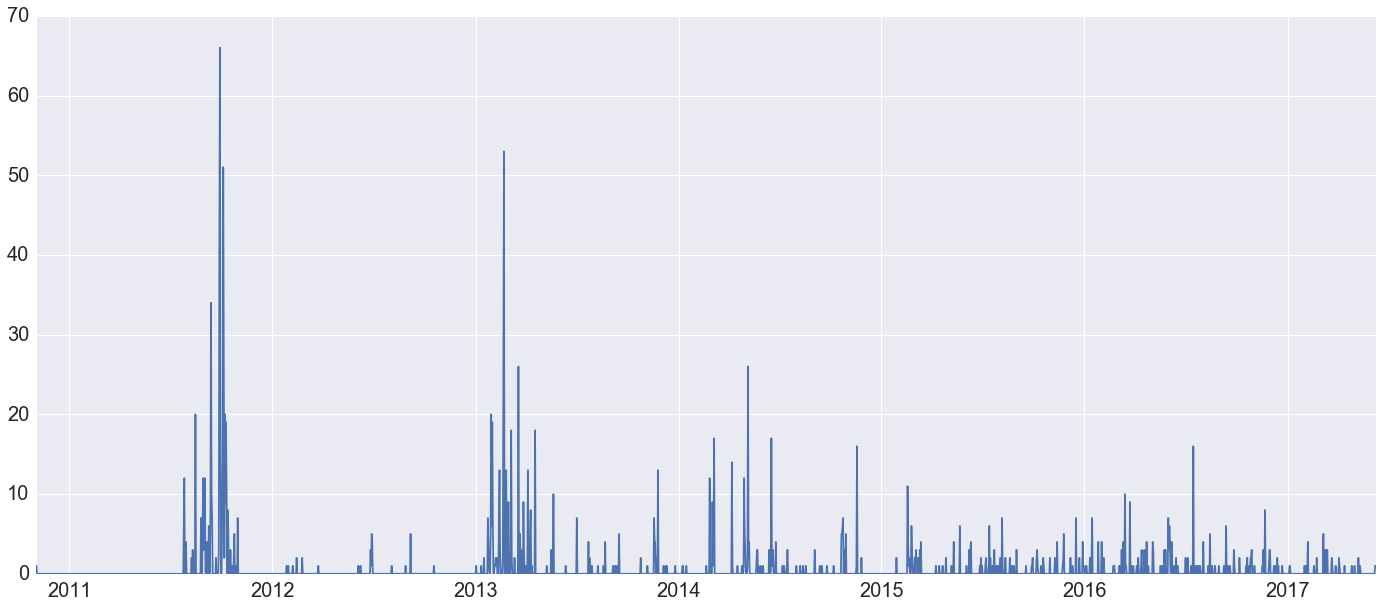

In [63]:
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('D').count().plot(figsize=(24, 10),
                                                                                                             fontsize=20)

In [64]:
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('D').count().sort_values(ascending=False)

2011-09-29    66
2013-02-21    53
2011-10-05    51
2011-09-28    40
2011-09-13    34
2013-02-20    28
2013-03-19    26
2011-10-06    26
2014-05-06    26
2011-10-08    20
2013-01-29    20
2011-08-16    20
2011-09-30    19
2013-01-31    19
2011-10-10    19
2013-04-18    18
2013-03-06    18
2014-03-06    17
2014-06-17    17
2016-07-15    16
2014-11-18    16
2014-04-07    14
2011-10-04    14
2013-11-25    13
2013-02-25    13
2013-04-05    13
2013-02-13    13
2014-04-29    12
2011-07-27    12
2014-02-26    12
              ..
2014-08-11     0
2014-08-10     0
2014-07-13     0
2014-07-14     0
2016-12-08     0
2014-07-17     0
2014-07-18     0
2014-07-19     0
2014-07-20     0
2014-07-21     0
2014-07-22     0
2014-07-23     0
2014-07-24     0
2014-07-25     0
2014-07-26     0
2014-07-27     0
2014-07-28     0
2014-07-29     0
2014-07-30     0
2014-07-31     0
2016-12-06     0
2014-08-02     0
2014-08-03     0
2014-08-04     0
2014-08-05     0
2014-08-06     0
2014-08-07     0
2016-12-05    

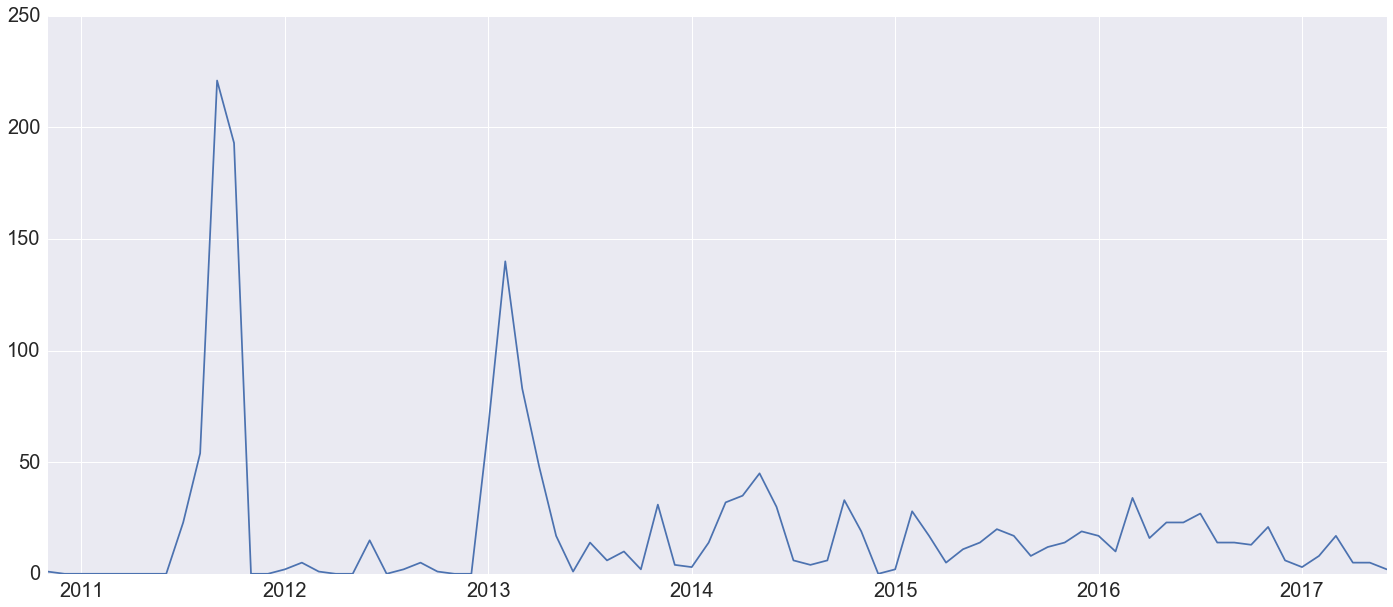

In [65]:
# Monthly dataset creation
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('M').count().plot(figsize=(24, 10), fontsize=20)

The trend is moderately upwards, but the graph as a whole is dominated by a couple of really big publication dates:

In [66]:
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('M').count().sort_values(ascending=False)

2011-09-30    221
2011-10-31    193
2013-02-28    140
2013-03-31     83
2013-01-31     66
2011-08-31     54
2013-04-30     48
2014-05-31     45
2014-04-30     35
2016-03-31     34
2014-10-31     33
2014-03-31     32
2013-11-30     31
2014-06-30     30
2015-02-28     28
2016-07-31     27
2011-07-31     23
2016-05-31     23
2016-06-30     23
2016-11-30     21
2015-07-31     20
2015-12-31     19
2014-11-30     19
2016-01-31     17
2015-08-31     17
2017-03-31     17
2015-03-31     17
2013-05-31     17
2016-04-30     16
2012-06-30     15
             ... 
2017-05-31      5
2015-04-30      5
2013-12-31      4
2014-08-31      4
2014-01-31      3
2017-01-31      3
2012-01-31      2
2012-08-31      2
2017-06-30      2
2013-10-31      2
2015-01-31      2
2013-06-30      1
2012-10-31      1
2010-11-30      1
2012-03-31      1
2012-11-30      0
2012-12-31      0
2011-12-31      0
2011-11-30      0
2012-04-30      0
2014-12-31      0
2012-05-31      0
2011-06-30      0
2011-05-31      0
2011-04-30

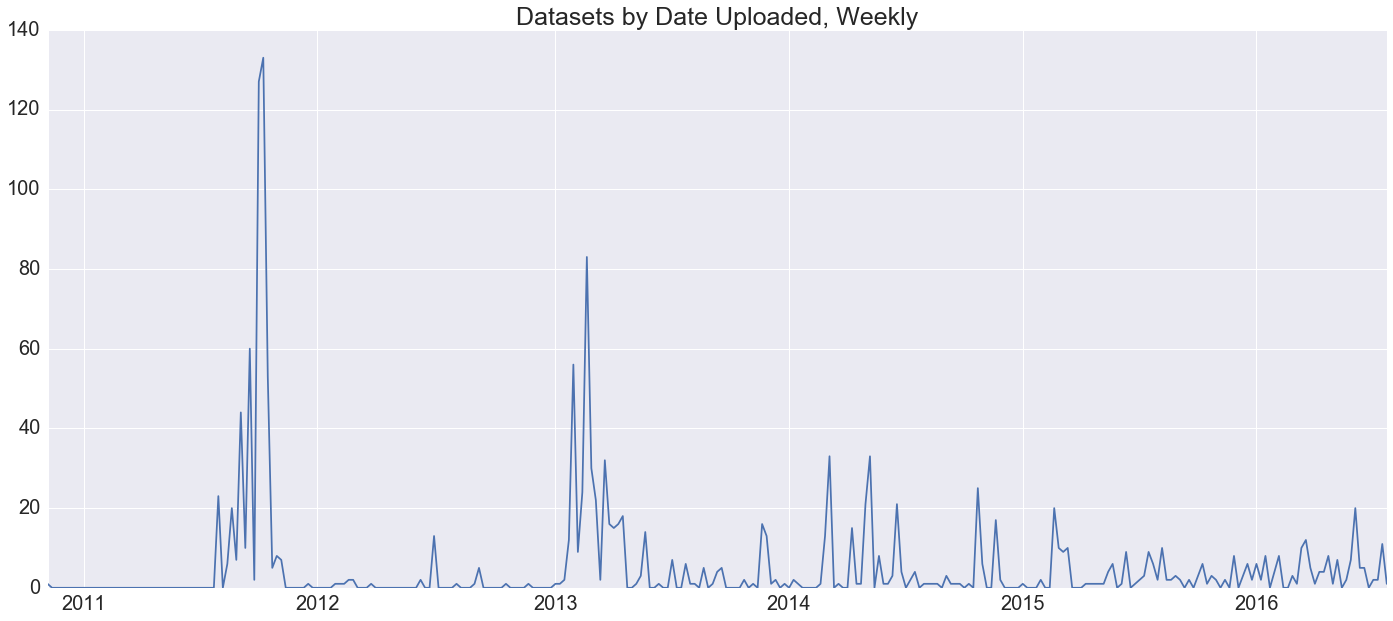

In [125]:
# Weekly dataset creation
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('W').count().plot(figsize=(24, 10), fontsize=20)
plt.title('Datasets by Date Uploaded, Weekly', fontsize=25)

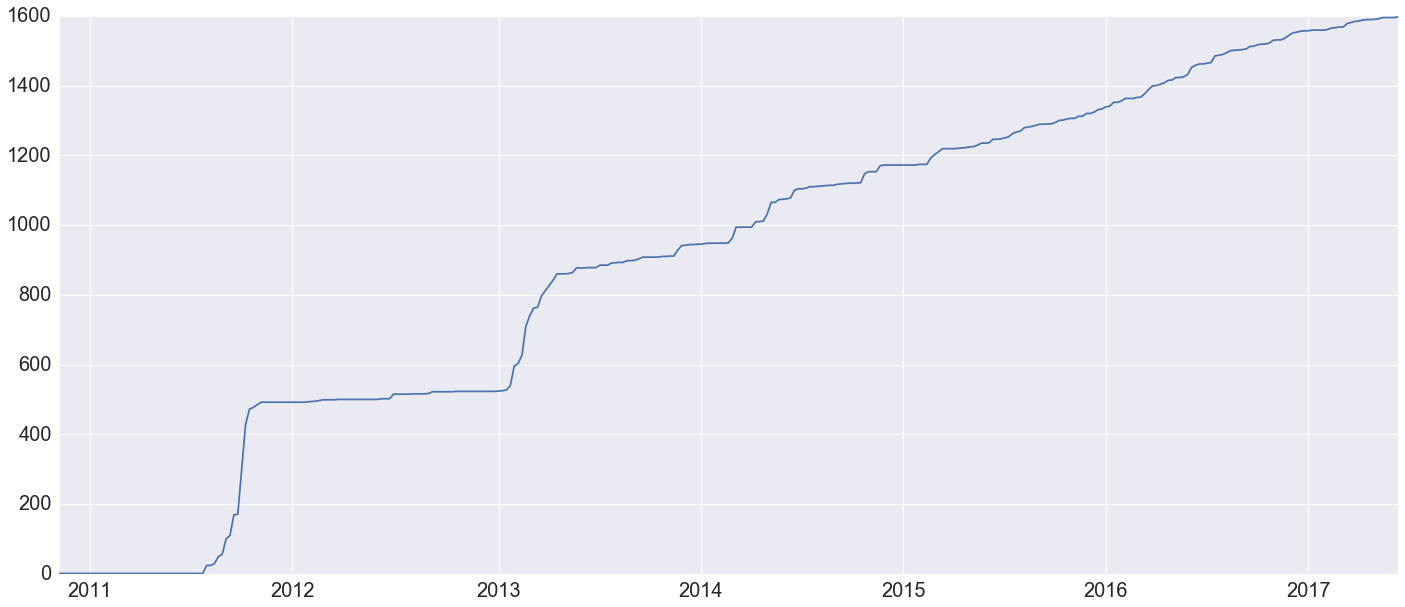

In [67]:
# Cumulative dataset count.
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

**Tables**

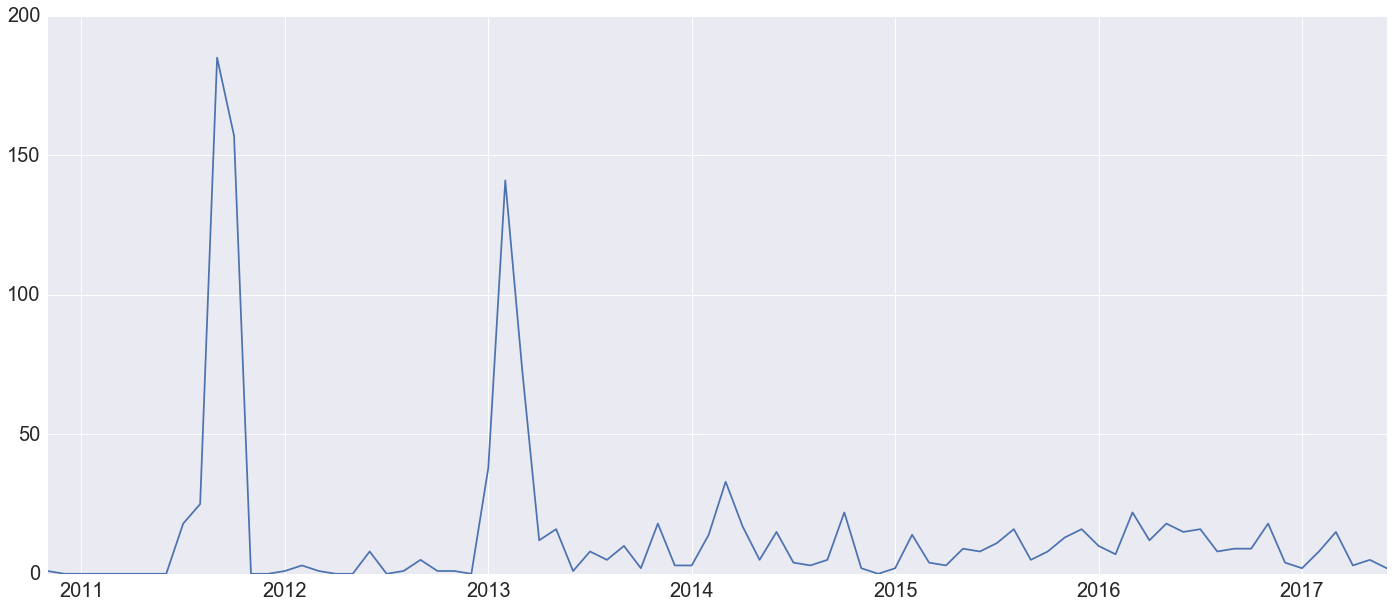

In [68]:
# Monthly tabular dataset creation
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('M').count().plot(figsize=(24, 10),
                                                                                                                           fontsize=20)

The trend is moderately upwards, but the graph as a whole is dominated by a couple of really big publication dates:

In [69]:
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('M').count().sort_values(ascending=False)

2011-09-30    185
2011-10-31    157
2013-02-28    141
2013-03-31     73
2013-01-31     38
2014-03-31     33
2011-08-31     25
2016-03-31     22
2014-10-31     22
2011-07-31     18
2016-11-30     18
2013-11-30     18
2016-05-31     18
2014-04-30     17
2015-12-31     16
2016-07-31     16
2015-08-31     16
2013-05-31     16
2014-06-30     15
2016-06-30     15
2017-03-31     15
2015-02-28     14
2014-02-28     14
2015-11-30     13
2016-04-30     12
2013-04-30     12
2015-07-31     11
2016-01-31     10
2013-09-30     10
2015-05-31      9
             ... 
2014-01-31      3
2014-08-31      3
2015-04-30      3
2017-04-30      3
2017-06-30      2
2017-01-31      2
2015-01-31      2
2014-11-30      2
2013-10-31      2
2012-11-30      1
2012-03-31      1
2012-10-31      1
2012-01-31      1
2010-11-30      1
2013-06-30      1
2012-08-31      1
2012-04-30      0
2012-05-31      0
2011-12-31      0
2012-07-31      0
2014-12-31      0
2012-12-31      0
2011-06-30      0
2011-05-31      0
2011-04-30

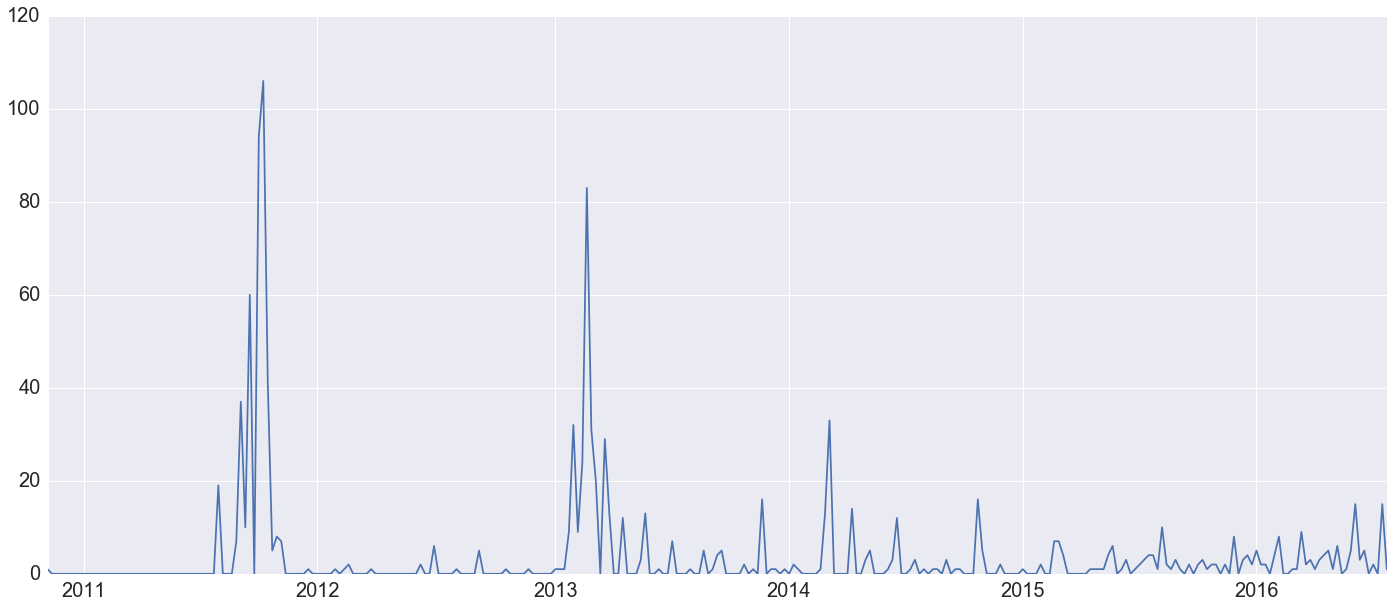

In [57]:
# Weekly endpoint creation
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('W').count().plot(figsize=(24, 10),
                                                                                                                           fontsize=20)

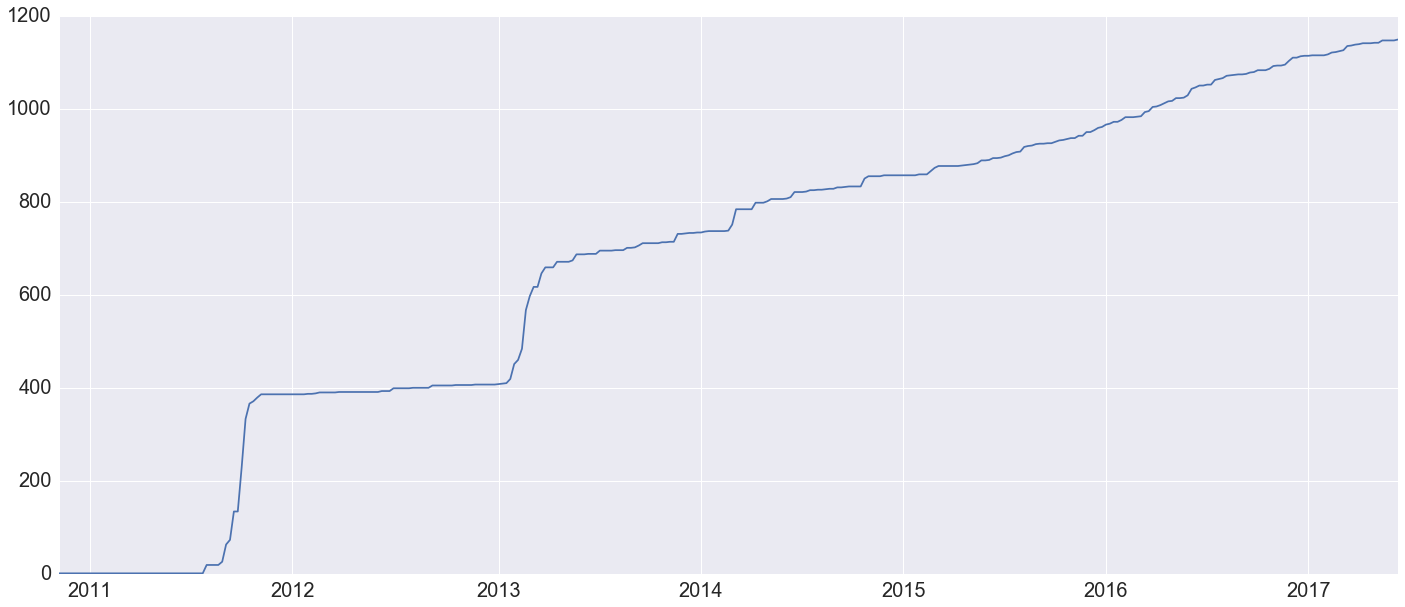

In [70]:
# Cumulative endpoint count.
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

### Updated-ness

In [71]:
def endpoint_update_dates(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update dates.
    """
    return pd.to_datetime(pd.Series(list(map(lambda d: d['resource']['updatedAt'], endpoints))))

**Endpoints**

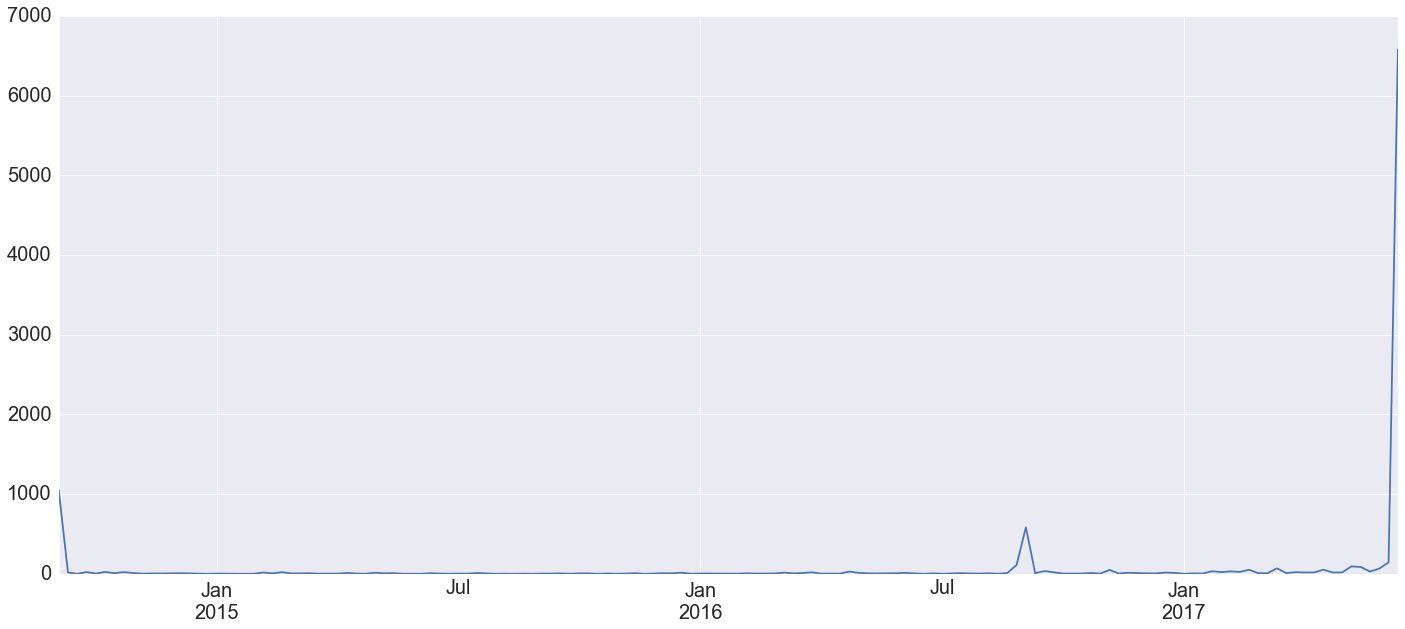

In [72]:
# Endpoints by weekly update recentness.
pd.Series(range(len(endpoints)), index=endpoint_update_dates(endpoints).values).resample('W').count().plot(figsize=(24, 10), fontsize=20)

In [73]:
sorted(endpoint_update_dates(endpoints).values)[0]

numpy.datetime64('2014-09-05T16:57:38.000000000')

Every endpoint was updated at least since September 2014, which seems to imply that there was some software update at around that time which touched and reset this field on every item in the portal. Update history since then is extremely sparse, which makes sense&mdash;everything more recent than a few weeks old is static or irregularly updated data. The recent hump is things that are "current".

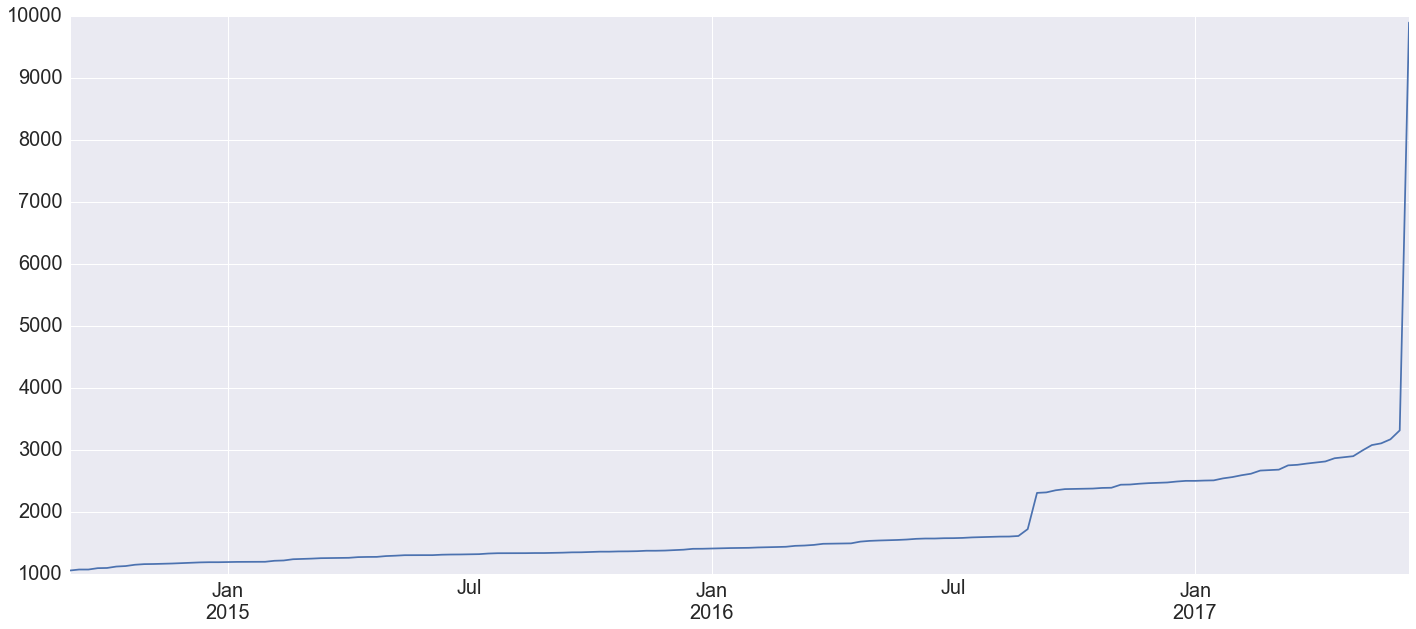

In [74]:
pd.Series(range(len(endpoints)), index=endpoint_update_dates(endpoints).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

**Datasets**

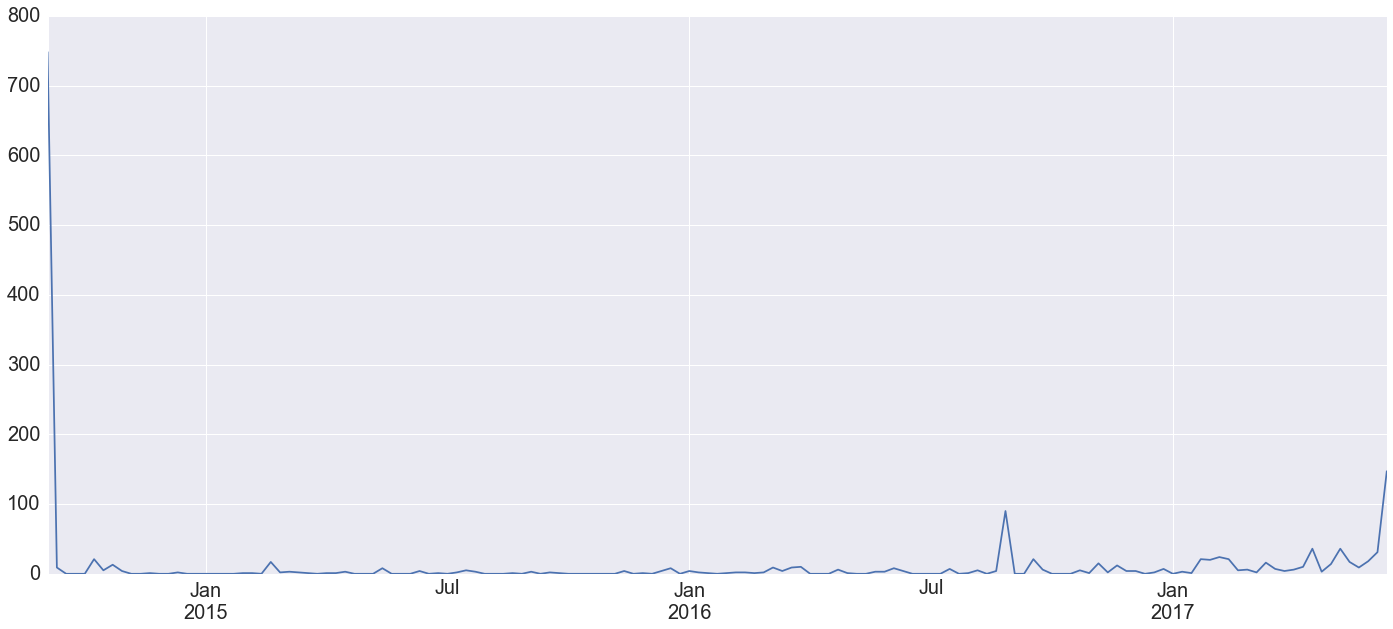

In [75]:
# Weekly updatedAt dates.
pd.Series(range(len(datasets)), index=endpoint_update_dates(datasets).values).resample('W').count().plot(figsize=(24, 10), fontsize=20)

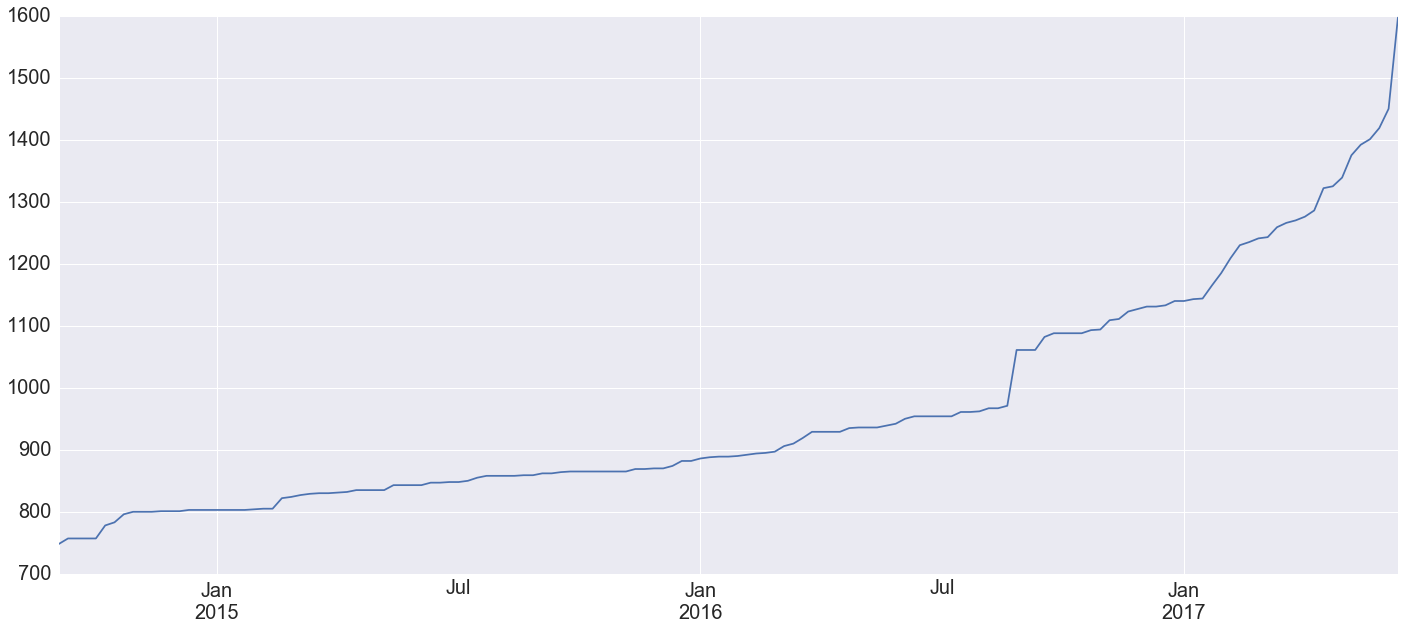

In [76]:
# Weekly updatedAt dates, cumulative.
pd.Series(range(len(datasets)), index=endpoint_update_dates(datasets).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

This plot is more meaningful if we invert. The following plot asks the question: how many datasets were updated in at least the $n$ most recent weeks? This allows us to actually vet the update frequency we are given in the related field against the reality of the Open Data update cycle.

(Note that because of the update issue mentioned above it's not possible to look any further back.)

In [77]:
backwards_facing_cumsum = (len(datasets) - pd.Series(range(len(datasets)), index=endpoint_update_dates(datasets).values).resample('W').count().cumsum())

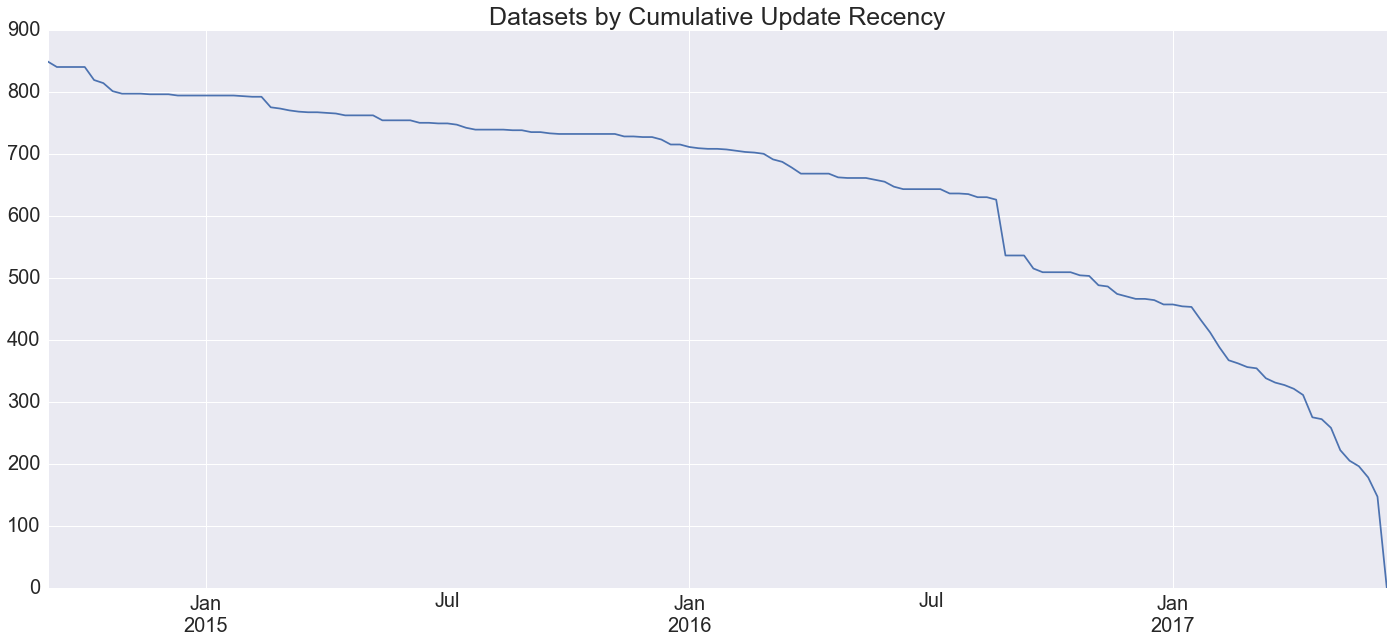

In [78]:
pd.Series(backwards_facing_cumsum).plot(figsize=(24, 10), fontsize=20)
plt.title('Datasets by Cumulative Update Recency', fontsize=25)

### Page views

In [79]:
def endpoint_monthy_page_views(endpoints):
    """
    Returns a pd.Series mapping endpoints to their monthly page views.
    """
    return pd.Series(list(map(lambda srs: srs['resource']['view_count']['page_views_last_month'], endpoints)))

**Endpoints**

In [80]:
endpoint_monthy_page_views(endpoints).sort_values(ascending=False)

1       90546
16      20735
2       20504
3        9303
8        3603
15       3484
6        2577
0        2550
4        2343
5        2310
9        1929
204      1874
12       1566
11       1491
26       1305
20       1272
10       1175
7        1140
188      1137
52       1095
45        969
433       951
27        907
72        867
84        862
13        759
17        743
530       723
22        655
321       635
        ...  
7088        0
9268        0
1589        0
7150        0
9282        0
7152        0
4967        0
3642        0
4968        0
1532        0
7233        0
4970        0
7200        0
1546        0
7196        0
7195        0
1555        0
7194        0
7193        0
7191        0
1561        0
9009        0
4981        0
7176        0
7174        0
7165        0
3620        0
3619        0
1581        0
8886        0
dtype: int64

Unsurprisingly (if you're familiar with these things) the result roughly follows [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), so it has to be visualized as a log plot.

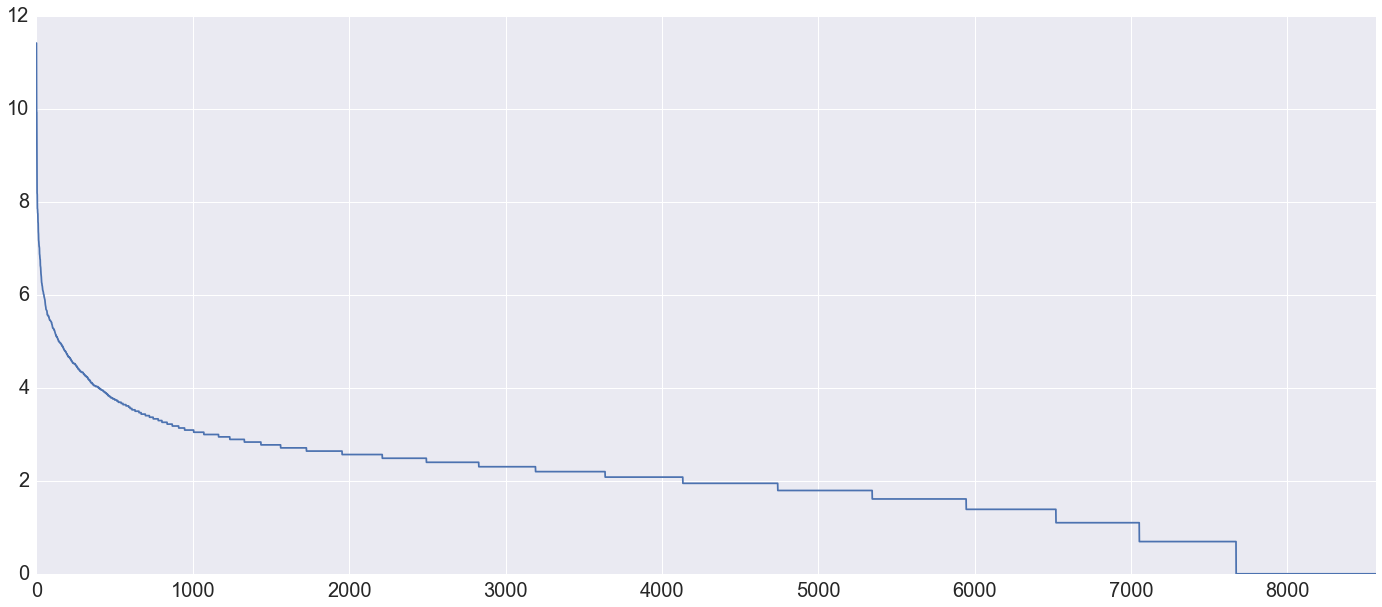

In [81]:
pd.Series(np.log([val for val in endpoint_monthy_page_views(endpoints).sort_values(ascending=False).values if val != 0])).plot(figsize=(24, 10), fontsize=20)

**Datasets**

No different.

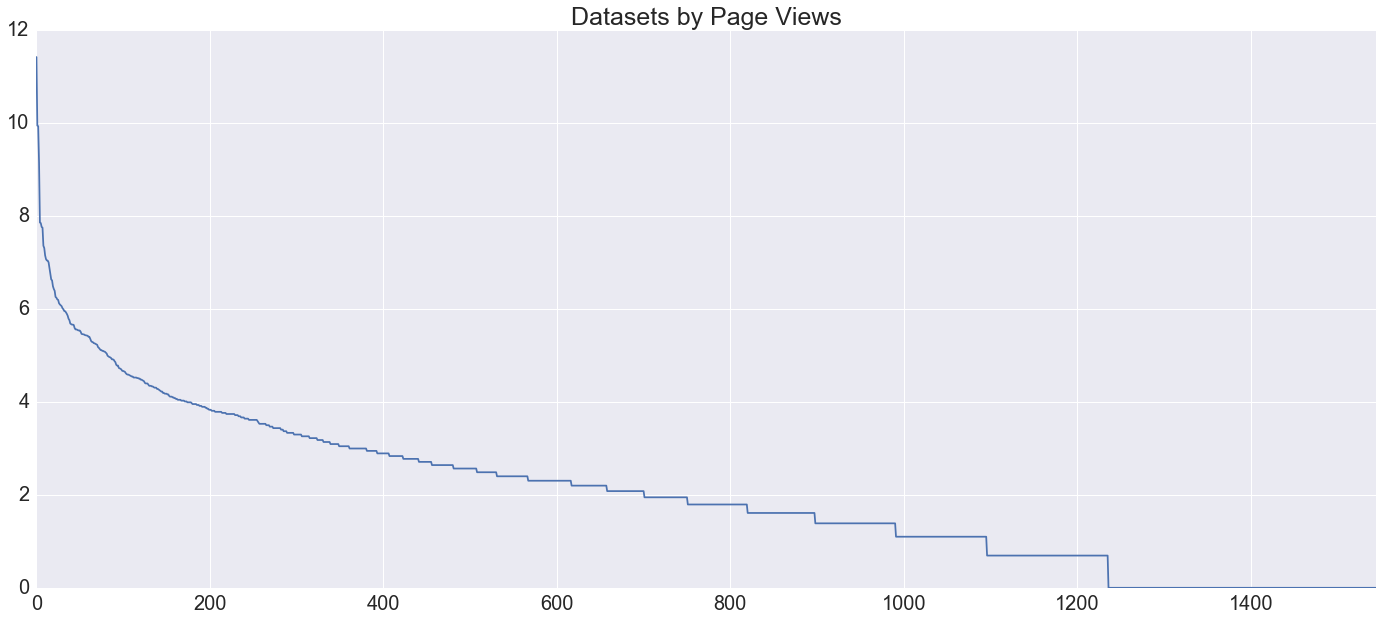

In [82]:
pd.Series(np.log([val for val in endpoint_monthy_page_views(datasets).sort_values(ascending=False).values if val != 0])).plot(figsize=(24, 10), fontsize=20)
plt.title('Datasets by Page Views', fontsize=25)

**Tables**

No different.

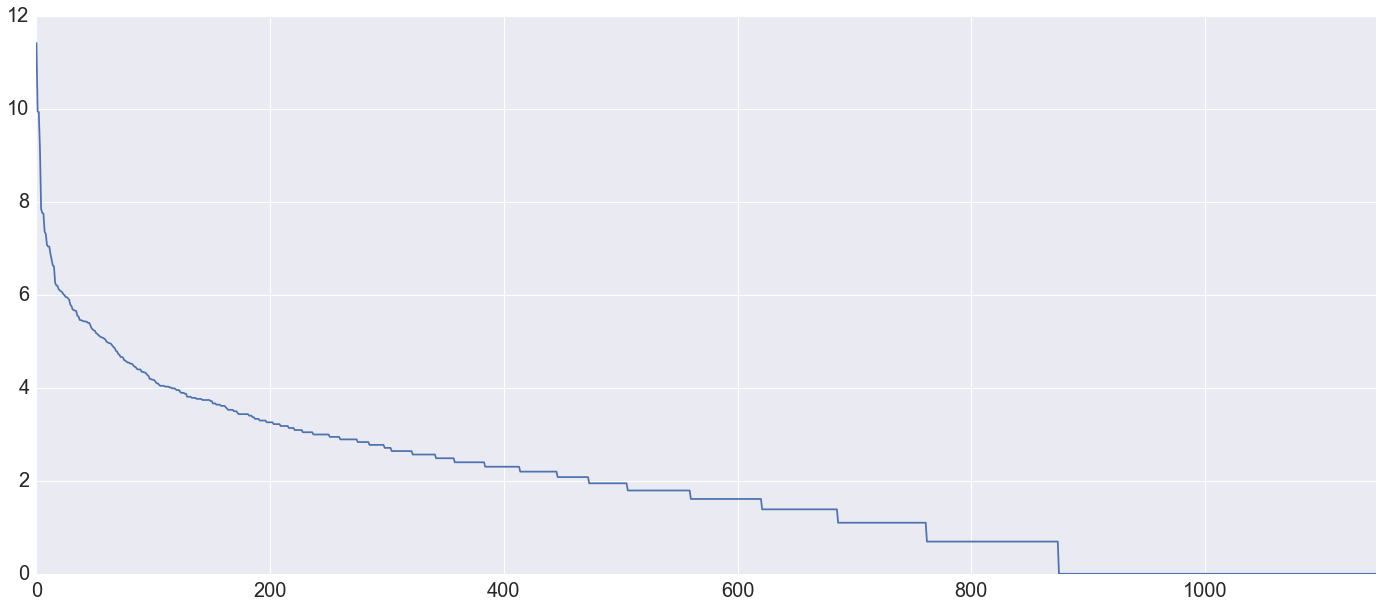

In [83]:
pd.Series(np.log([val for val in endpoint_monthy_page_views(tabular_datasets).sort_values(ascending=False).values if val != 0])).plot(figsize=(24, 10), fontsize=20)

### Resource Type

In [84]:
def endpoint_types(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update dates.
    """
    return pd.Series(list(map(lambda d: d['resource']['type'], endpoints)))

**Endpoints**

Here, `dataset==table`.

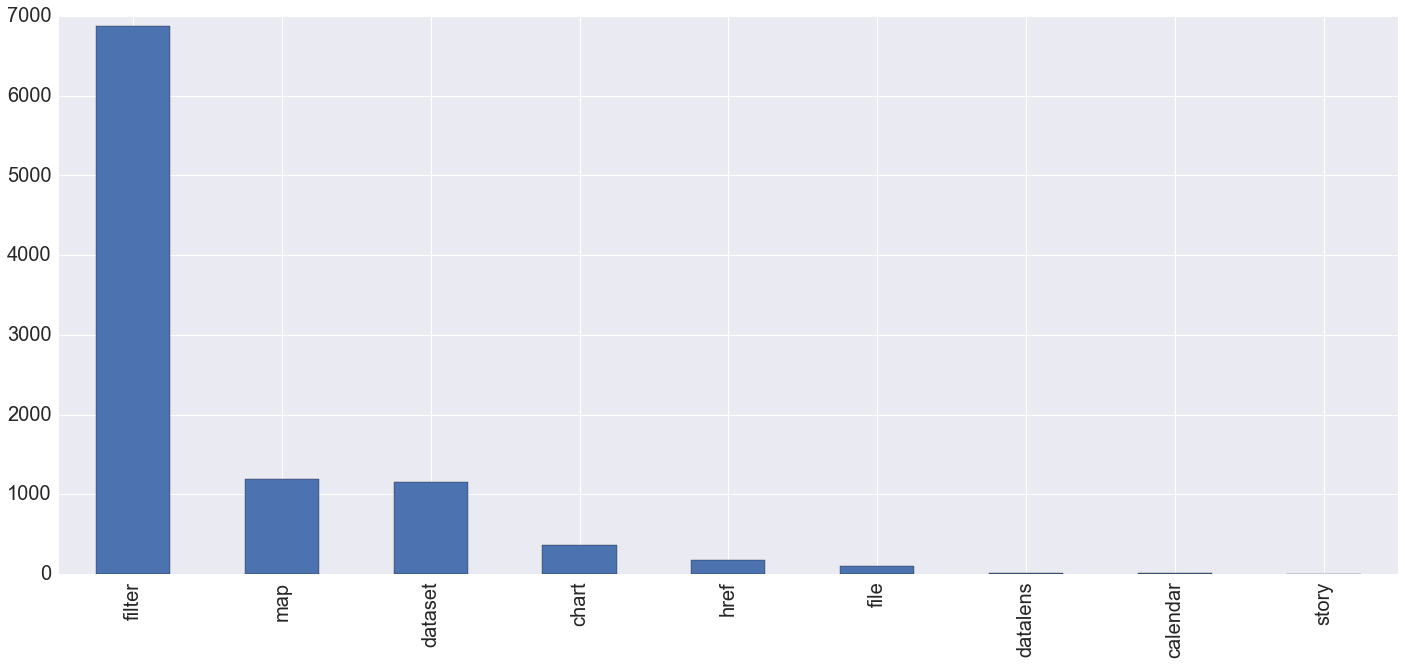

In [85]:
endpoint_types(endpoints).value_counts().plot(kind='bar', figsize=(24, 10), fontsize=20)

Filters are dominated by topic-specific views of 311 call center data, of which there are thousands. These in turn dominate the rest of the data on the portal, at least in terms of raw counts!

### Column names

In [86]:
def endpoint_column_names(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update dates.
    """
    all_columns = []
    for endpoint in endpoints:
        all_columns += endpoint['resource']['columns_name']
    return pd.Series(all_columns)

In [87]:
len(endpoint_column_names(endpoints))

265903

In [88]:
len(endpoint_column_names(tabular_datasets))

17508